In [13]:
DATASET_DIR = ''
#GLOVE_DIR = './glove.6B/'
SAVE_DIR = './'

import os
import pandas as pd
import keras
from keras.callbacks import EarlyStopping

environment='L'


In [14]:

if environment == 'S':
    os.environ["CUDA_VISIBLE_DEVICES"] = '1'  
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth =\
        True
    sess = tf.Session(config=config)
    keras.backend.set_session(sess)
elif environment == 'L':
    os.chdir("/Users/omerorhan/Desktop/lexinsight/AutomaticTextUnderstanding/venv/Source")

In [20]:


X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.csv'), encoding='ISO-8859-1')
X = (X[(X["essay_set"] == 1) | (X["essay_set"] == 2)])
#X = (X[(X["essay_set"] == 1)])
y = X['domain1_score_copy']
X = X.dropna(axis=1)
X = X.drop(columns=['rater1_domain1'])
os.chdir("/Users/omerorhan/Desktop/lexinsight/AutomaticTextUnderstanding/venv/Source")


Preprocessing the Data
We will preprocess all essays and convert them to feature vectors so that they can be fed into the RNN.

These are all helper functions used to clean the essays.

In [5]:
minimum_scores = [-1, 2, 1, 0, 0, 0, 0, 0, 0]
maximum_scores = [-1, 12, 6, 3, 3, 4, 4, 30, 60]

import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            num_words += 1
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs


Defining the model
Here we define a 2-Layer LSTM Model.

Note that instead of using sigmoid activation in the output layer we will use Relu since we are not normalising training labels.



In [12]:

from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K
from keras.utils.np_utils import to_categorical
from keras import optimizers


def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.2))
    model.add(Dropout(0.1))
    #model.add(Dense(12, activation='softmax'))
    model.add(Dense(12, activation='sigmoid'))
    #adam = optimizers.Adam(lr = 0.01)
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model
'''
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K

def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model
'''

'\nfrom keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten\nfrom keras.models import Sequential, load_model, model_from_config\nimport keras.backend as K\n\ndef get_model():\n    """Define the model."""\n    model = Sequential()\n    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))\n    model.add(LSTM(64, recurrent_dropout=0.4))\n    model.add(Dropout(0.5))\n    model.add(Dense(1, activation=\'relu\'))\n\n    model.compile(loss=\'mean_squared_error\', optimizer=\'rmsprop\', metrics=[\'mae\'])\n    model.summary()\n\n    return model\n'

Training Phase
Now we train the model on the dataset.

We will use 5-Fold Cross Validation and measure the Quadratic Weighted Kappa for each fold. We will then calculate Average Kappa for all the folds.


--------Fold 1--------



Training Word2Vec Model...


/anaconda3/envs/tf-cpu/lib/python3.5/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                780       
Total params: 815,420
Trainable params: 815,420
Non-trainable params: 0
_________________________________________________________________


Train on 2866 samples, validate on 200 samples
Epoch 1/50


  64/2866 [..............................] - ETA: 1:43 - loss: 2.4851 - acc: 0.0156

 192/2866 [=>............................] - ETA: 33s - loss: 2.4813 - acc: 0.2031 

 320/2866 [==>...........................] - ETA: 19s - loss: 2.4758 - acc: 0.2750

 448/2866 [===>..........................] - ETA: 13s - loss: 2.4695 - acc: 0.3036

 576/2866 [=====>........................] - ETA: 10s - loss: 2.4640 - acc: 0.3142

 704/2866 [======>.......................] - ETA: 8s - loss: 2.4577 - acc: 0.3153 

 832/2866 [=======>......................] - ETA: 6s - loss: 2.4489 - acc: 0.3257

 960/2866 [=========>....................] - ETA: 5s - loss: 2.4415 - acc: 0.3229

1088/2866 [==========>...................] - ETA: 4s - loss: 2.4300 - acc: 0.3309

1216/2866 [===========>..................] - ETA: 3s - loss: 2.4149 - acc: 0.3413

1344/2866 [=============>................] - ETA: 3s - loss: 2.4026 - acc: 0.3415

1472/2866 [==============>...............] - ETA: 2s - loss: 2.3866 - acc: 0.3458

1600/2866 [===============>..............] - ETA: 2s - loss: 2.3674 - acc: 0.3481

1728/2866 [=================>............] - ETA: 2s - loss: 2.3443 - acc: 0.3547

1856/2866 [==================>...........] - ETA: 1s - loss: 2.3234 - acc: 0.3567

1984/2866 [===================>..........] - ETA: 1s - loss: 2.2990 - acc: 0.3604

2112/2866 [=====================>........] - ETA: 1s - loss: 2.2691 - acc: 0.3655

2240/2866 [======================>.......] - ETA: 0s - loss: 2.2514 - acc: 0.3638

2368/2866 [=======================>......] - ETA: 0s - loss: 2.2435 - acc: 0.3606

2496/2866 [=========================>....] - ETA: 0s - loss: 2.2227 - acc: 0.3622

2624/2866 [==========================>...] - ETA: 0s - loss: 2.2023 - acc: 0.3636

2752/2866 [===========================>..] - ETA: 0s - loss: 2.1855 - acc: 0.3641

2866/2866 [==============================] - 4s 1ms/step - loss: 2.1808 - acc: 0.3618 - val_loss: 1.9496 - val_acc: 0.3800


Epoch 2/50
  64/2866 [..............................] - ETA: 1s - loss: 1.6874 - acc: 0.4531

 192/2866 [=>............................] - ETA: 1s - loss: 1.8153 - acc: 0.4115

 320/2866 [==>...........................] - ETA: 1s - loss: 1.7986 - acc: 0.3688

 448/2866 [===>..........................] - ETA: 1s - loss: 1.8281 - acc: 0.3527

 576/2866 [=====>........................] - ETA: 1s - loss: 1.8168 - acc: 0.3628

 704/2866 [======>.......................] - ETA: 1s - loss: 1.8427 - acc: 0.3565

 832/2866 [=======>......................] - ETA: 1s - loss: 1.8554 - acc: 0.3546

 960/2866 [=========>....................] - ETA: 0s - loss: 1.8627 - acc: 0.3563

1088/2866 [==========>...................] - ETA: 0s - loss: 1.8641 - acc: 0.3612

1216/2866 [===========>..................] - ETA: 0s - loss: 1.8507 - acc: 0.3660

1344/2866 [=============>................] - ETA: 0s - loss: 1.8442 - acc: 0.3698

1472/2866 [==============>...............] - ETA: 0s - loss: 1.8367 - acc: 0.3791

1600/2866 [===============>..............] - ETA: 0s - loss: 1.8303 - acc: 0.3800

1728/2866 [=================>............] - ETA: 0s - loss: 1.8311 - acc: 0.3773

1856/2866 [==================>...........] - ETA: 0s - loss: 1.8273 - acc: 0.3766

1984/2866 [===================>..........] - ETA: 0s - loss: 1.8285 - acc: 0.3785

2112/2866 [=====================>........] - ETA: 0s - loss: 1.8256 - acc: 0.3759

2240/2866 [======================>.......] - ETA: 0s - loss: 1.8280 - acc: 0.3746

2368/2866 [=======================>......] - ETA: 0s - loss: 1.8223 - acc: 0.3763

2496/2866 [=========================>....] - ETA: 0s - loss: 1.8212 - acc: 0.3782

2624/2866 [==========================>...] - ETA: 0s - loss: 1.8152 - acc: 0.3784

2752/2866 [===========================>..] - ETA: 0s - loss: 1.8111 - acc: 0.3786

2866/2866 [==============================] - 1s 483us/step - loss: 1.8062 - acc: 0.3779 - val_loss: 1.8285 - val_acc: 0.3800


Epoch 3/50


  64/2866 [..............................] - ETA: 2s - loss: 1.7181 - acc: 0.3594

 192/2866 [=>............................] - ETA: 1s - loss: 1.7462 - acc: 0.3177

 320/2866 [==>...........................] - ETA: 1s - loss: 1.7340 - acc: 0.3594

 448/2866 [===>..........................] - ETA: 1s - loss: 1.7319 - acc: 0.3549

 576/2866 [=====>........................] - ETA: 1s - loss: 1.7520 - acc: 0.3524

 704/2866 [======>.......................] - ETA: 1s - loss: 1.7282 - acc: 0.3580

 832/2866 [=======>......................] - ETA: 0s - loss: 1.7301 - acc: 0.3522

 960/2866 [=========>....................] - ETA: 0s - loss: 1.7234 - acc: 0.3510

1088/2866 [==========>...................] - ETA: 0s - loss: 1.7295 - acc: 0.3548

1216/2866 [===========>..................] - ETA: 0s - loss: 1.7265 - acc: 0.3561

1344/2866 [=============>................] - ETA: 0s - loss: 1.7196 - acc: 0.3571

1472/2866 [==============>...............] - ETA: 0s - loss: 1.7106 - acc: 0.3580

1600/2866 [===============>..............] - ETA: 0s - loss: 1.7088 - acc: 0.3613

1728/2866 [=================>............] - ETA: 0s - loss: 1.7179 - acc: 0.3600

1856/2866 [==================>...........] - ETA: 0s - loss: 1.7105 - acc: 0.3648

1984/2866 [===================>..........] - ETA: 0s - loss: 1.7016 - acc: 0.3654

2112/2866 [=====================>........] - ETA: 0s - loss: 1.6901 - acc: 0.3712

2240/2866 [======================>.......] - ETA: 0s - loss: 1.6842 - acc: 0.3772

2368/2866 [=======================>......] - ETA: 0s - loss: 1.6839 - acc: 0.3763

2496/2866 [=========================>....] - ETA: 0s - loss: 1.6832 - acc: 0.3794

2624/2866 [==========================>...] - ETA: 0s - loss: 1.6791 - acc: 0.3822

2752/2866 [===========================>..] - ETA: 0s - loss: 1.6787 - acc: 0.3823

2866/2866 [==============================] - 1s 474us/step - loss: 1.6797 - acc: 0.3824 - val_loss: 1.7642 - val_acc: 0.3800


Epoch 4/50


  64/2866 [..............................] - ETA: 2s - loss: 1.5940 - acc: 0.3750

 192/2866 [=>............................] - ETA: 1s - loss: 1.6722 - acc: 0.3542

 320/2866 [==>...........................] - ETA: 1s - loss: 1.6224 - acc: 0.3906

 448/2866 [===>..........................] - ETA: 1s - loss: 1.6446 - acc: 0.3884

 576/2866 [=====>........................] - ETA: 1s - loss: 1.6514 - acc: 0.3733

 704/2866 [======>.......................] - ETA: 1s - loss: 1.6444 - acc: 0.3892

 832/2866 [=======>......................] - ETA: 0s - loss: 1.6463 - acc: 0.3882

 960/2866 [=========>....................] - ETA: 0s - loss: 1.6537 - acc: 0.3906

1088/2866 [==========>...................] - ETA: 0s - loss: 1.6519 - acc: 0.3915

1216/2866 [===========>..................] - ETA: 0s - loss: 1.6510 - acc: 0.3906

1344/2866 [=============>................] - ETA: 0s - loss: 1.6416 - acc: 0.3936

1472/2866 [==============>...............] - ETA: 0s - loss: 1.6415 - acc: 0.3967

1600/2866 [===============>..............] - ETA: 0s - loss: 1.6296 - acc: 0.4006

1728/2866 [=================>............] - ETA: 0s - loss: 1.6387 - acc: 0.3964

1856/2866 [==================>...........] - ETA: 0s - loss: 1.6400 - acc: 0.3939

1984/2866 [===================>..........] - ETA: 0s - loss: 1.6421 - acc: 0.3931

2112/2866 [=====================>........] - ETA: 0s - loss: 1.6444 - acc: 0.3925

2240/2866 [======================>.......] - ETA: 0s - loss: 1.6427 - acc: 0.3915

2368/2866 [=======================>......] - ETA: 0s - loss: 1.6321 - acc: 0.3961

2496/2866 [=========================>....] - ETA: 0s - loss: 1.6215 - acc: 0.3990

2624/2866 [==========================>...] - ETA: 0s - loss: 1.6178 - acc: 0.3990

2752/2866 [===========================>..] - ETA: 0s - loss: 1.6195 - acc: 0.3979

2816/2866 [============================>.] - ETA: 0s - loss: 1.6239 - acc: 0.3963

2866/2866 [==============================] - 1s 495us/step - loss: 1.6222 - acc: 0.3957 - val_loss: 1.7111 - val_acc: 0.3900


Epoch 5/50


  64/2866 [..............................] - ETA: 1s - loss: 1.6329 - acc: 0.3906

 192/2866 [=>............................] - ETA: 1s - loss: 1.5409 - acc: 0.4375

 320/2866 [==>...........................] - ETA: 1s - loss: 1.5607 - acc: 0.4281

 448/2866 [===>..........................] - ETA: 1s - loss: 1.5934 - acc: 0.4062

 576/2866 [=====>........................] - ETA: 1s - loss: 1.5953 - acc: 0.4010

 704/2866 [======>.......................] - ETA: 1s - loss: 1.5985 - acc: 0.4062

 832/2866 [=======>......................] - ETA: 0s - loss: 1.5906 - acc: 0.4159

 960/2866 [=========>....................] - ETA: 0s - loss: 1.5921 - acc: 0.4177

1088/2866 [==========>...................] - ETA: 0s - loss: 1.5853 - acc: 0.4219

1216/2866 [===========>..................] - ETA: 0s - loss: 1.5822 - acc: 0.4252

1344/2866 [=============>................] - ETA: 0s - loss: 1.5884 - acc: 0.4152

1472/2866 [==============>...............] - ETA: 0s - loss: 1.5817 - acc: 0.4158

1600/2866 [===============>..............] - ETA: 0s - loss: 1.5921 - acc: 0.4100

1728/2866 [=================>............] - ETA: 0s - loss: 1.5834 - acc: 0.4149

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5886 - acc: 0.4127

1984/2866 [===================>..........] - ETA: 0s - loss: 1.5931 - acc: 0.4103

2112/2866 [=====================>........] - ETA: 0s - loss: 1.5956 - acc: 0.4072

2240/2866 [======================>.......] - ETA: 0s - loss: 1.5972 - acc: 0.4049

2368/2866 [=======================>......] - ETA: 0s - loss: 1.5913 - acc: 0.4071

2496/2866 [=========================>....] - ETA: 0s - loss: 1.5875 - acc: 0.4119

2624/2866 [==========================>...] - ETA: 0s - loss: 1.5869 - acc: 0.4139

2752/2866 [===========================>..] - ETA: 0s - loss: 1.5863 - acc: 0.4157

2866/2866 [==============================] - 1s 478us/step - loss: 1.5805 - acc: 0.4138 - val_loss: 1.6762 - val_acc: 0.3950


Epoch 6/50


  64/2866 [..............................] - ETA: 2s - loss: 1.3305 - acc: 0.5000

 192/2866 [=>............................] - ETA: 1s - loss: 1.4655 - acc: 0.4323

 320/2866 [==>...........................] - ETA: 1s - loss: 1.5510 - acc: 0.4094

 448/2866 [===>..........................] - ETA: 1s - loss: 1.5312 - acc: 0.4174

 576/2866 [=====>........................] - ETA: 1s - loss: 1.5147 - acc: 0.4306

 704/2866 [======>.......................] - ETA: 1s - loss: 1.5251 - acc: 0.4332

 832/2866 [=======>......................] - ETA: 0s - loss: 1.5373 - acc: 0.4327

 960/2866 [=========>....................] - ETA: 0s - loss: 1.5544 - acc: 0.4240

1088/2866 [==========>...................] - ETA: 0s - loss: 1.5647 - acc: 0.4191

1216/2866 [===========>..................] - ETA: 0s - loss: 1.5561 - acc: 0.4252

1344/2866 [=============>................] - ETA: 0s - loss: 1.5669 - acc: 0.4182

1472/2866 [==============>...............] - ETA: 0s - loss: 1.5749 - acc: 0.4144

1600/2866 [===============>..............] - ETA: 0s - loss: 1.5698 - acc: 0.4188

1728/2866 [=================>............] - ETA: 0s - loss: 1.5737 - acc: 0.4149

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5766 - acc: 0.4154

1984/2866 [===================>..........] - ETA: 0s - loss: 1.5777 - acc: 0.4143

2112/2866 [=====================>........] - ETA: 0s - loss: 1.5686 - acc: 0.4157

2240/2866 [======================>.......] - ETA: 0s - loss: 1.5651 - acc: 0.4147

2368/2866 [=======================>......] - ETA: 0s - loss: 1.5626 - acc: 0.4126

2496/2866 [=========================>....] - ETA: 0s - loss: 1.5654 - acc: 0.4123

2624/2866 [==========================>...] - ETA: 0s - loss: 1.5640 - acc: 0.4120

2752/2866 [===========================>..] - ETA: 0s - loss: 1.5590 - acc: 0.4142

2866/2866 [==============================] - 1s 477us/step - loss: 1.5614 - acc: 0.4138 - val_loss: 1.6491 - val_acc: 0.3800


Epoch 7/50


  64/2866 [..............................] - ETA: 2s - loss: 1.3798 - acc: 0.4688

 192/2866 [=>............................] - ETA: 1s - loss: 1.4749 - acc: 0.4323

 320/2866 [==>...........................] - ETA: 1s - loss: 1.4715 - acc: 0.4406

 448/2866 [===>..........................] - ETA: 1s - loss: 1.4813 - acc: 0.4330

 576/2866 [=====>........................] - ETA: 1s - loss: 1.4790 - acc: 0.4323

 704/2866 [======>.......................] - ETA: 1s - loss: 1.5019 - acc: 0.4332

 832/2866 [=======>......................] - ETA: 1s - loss: 1.5067 - acc: 0.4291

 960/2866 [=========>....................] - ETA: 0s - loss: 1.5131 - acc: 0.4250

1088/2866 [==========>...................] - ETA: 0s - loss: 1.5335 - acc: 0.4108

1216/2866 [===========>..................] - ETA: 0s - loss: 1.5325 - acc: 0.4137

1344/2866 [=============>................] - ETA: 0s - loss: 1.5460 - acc: 0.4100

1472/2866 [==============>...............] - ETA: 0s - loss: 1.5543 - acc: 0.4090

1600/2866 [===============>..............] - ETA: 0s - loss: 1.5623 - acc: 0.4094

1728/2866 [=================>............] - ETA: 0s - loss: 1.5510 - acc: 0.4126

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5529 - acc: 0.4116

1984/2866 [===================>..........] - ETA: 0s - loss: 1.5488 - acc: 0.4138

2112/2866 [=====================>........] - ETA: 0s - loss: 1.5436 - acc: 0.4152

2240/2866 [======================>.......] - ETA: 0s - loss: 1.5443 - acc: 0.4147

2368/2866 [=======================>......] - ETA: 0s - loss: 1.5490 - acc: 0.4126

2496/2866 [=========================>....] - ETA: 0s - loss: 1.5431 - acc: 0.4143

2624/2866 [==========================>...] - ETA: 0s - loss: 1.5413 - acc: 0.4150

2752/2866 [===========================>..] - ETA: 0s - loss: 1.5447 - acc: 0.4132

2866/2866 [==============================] - 1s 485us/step - loss: 1.5494 - acc: 0.4100 - val_loss: 1.6280 - val_acc: 0.4000


Epoch 8/50


  64/2866 [..............................] - ETA: 2s - loss: 1.5307 - acc: 0.4375

 192/2866 [=>............................] - ETA: 1s - loss: 1.4923 - acc: 0.4219

 320/2866 [==>...........................] - ETA: 1s - loss: 1.4685 - acc: 0.4531

 448/2866 [===>..........................] - ETA: 1s - loss: 1.5066 - acc: 0.4375

 576/2866 [=====>........................] - ETA: 1s - loss: 1.4920 - acc: 0.4479

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4892 - acc: 0.4446

 832/2866 [=======>......................] - ETA: 0s - loss: 1.4957 - acc: 0.4459

 960/2866 [=========>....................] - ETA: 0s - loss: 1.4967 - acc: 0.4437

1088/2866 [==========>...................] - ETA: 0s - loss: 1.4928 - acc: 0.4403

1216/2866 [===========>..................] - ETA: 0s - loss: 1.5074 - acc: 0.4359

1344/2866 [=============>................] - ETA: 0s - loss: 1.5115 - acc: 0.4375

1472/2866 [==============>...............] - ETA: 0s - loss: 1.5071 - acc: 0.4416

1600/2866 [===============>..............] - ETA: 0s - loss: 1.5151 - acc: 0.4394

1728/2866 [=================>............] - ETA: 0s - loss: 1.5177 - acc: 0.4317

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5247 - acc: 0.4294

1984/2866 [===================>..........] - ETA: 0s - loss: 1.5265 - acc: 0.4279

2112/2866 [=====================>........] - ETA: 0s - loss: 1.5314 - acc: 0.4261

2240/2866 [======================>.......] - ETA: 0s - loss: 1.5355 - acc: 0.4254

2368/2866 [=======================>......] - ETA: 0s - loss: 1.5346 - acc: 0.4257

2496/2866 [=========================>....] - ETA: 0s - loss: 1.5418 - acc: 0.4199

2624/2866 [==========================>...] - ETA: 0s - loss: 1.5427 - acc: 0.4200

2752/2866 [===========================>..] - ETA: 0s - loss: 1.5422 - acc: 0.4211

2866/2866 [==============================] - 1s 473us/step - loss: 1.5402 - acc: 0.4225 - val_loss: 1.6123 - val_acc: 0.3900


Epoch 9/50


  64/2866 [..............................] - ETA: 2s - loss: 1.7119 - acc: 0.3750

 192/2866 [=>............................] - ETA: 1s - loss: 1.5523 - acc: 0.3802

 320/2866 [==>...........................] - ETA: 1s - loss: 1.5152 - acc: 0.4062

 448/2866 [===>..........................] - ETA: 1s - loss: 1.5447 - acc: 0.4018

 576/2866 [=====>........................] - ETA: 1s - loss: 1.5619 - acc: 0.3872

 704/2866 [======>.......................] - ETA: 1s - loss: 1.5462 - acc: 0.4020

 832/2866 [=======>......................] - ETA: 0s - loss: 1.5441 - acc: 0.4050

 960/2866 [=========>....................] - ETA: 0s - loss: 1.5422 - acc: 0.4062

1088/2866 [==========>...................] - ETA: 0s - loss: 1.5354 - acc: 0.4090

1216/2866 [===========>..................] - ETA: 0s - loss: 1.5201 - acc: 0.4169

1344/2866 [=============>................] - ETA: 0s - loss: 1.5258 - acc: 0.4182

1472/2866 [==============>...............] - ETA: 0s - loss: 1.5237 - acc: 0.4164

1600/2866 [===============>..............] - ETA: 0s - loss: 1.5263 - acc: 0.4181

1728/2866 [=================>............] - ETA: 0s - loss: 1.5175 - acc: 0.4219

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5208 - acc: 0.4203

1984/2866 [===================>..........] - ETA: 0s - loss: 1.5165 - acc: 0.4219

2112/2866 [=====================>........] - ETA: 0s - loss: 1.5240 - acc: 0.4186

2240/2866 [======================>.......] - ETA: 0s - loss: 1.5262 - acc: 0.4179

2368/2866 [=======================>......] - ETA: 0s - loss: 1.5320 - acc: 0.4164

2496/2866 [=========================>....] - ETA: 0s - loss: 1.5346 - acc: 0.4163

2624/2866 [==========================>...] - ETA: 0s - loss: 1.5396 - acc: 0.4143

2752/2866 [===========================>..] - ETA: 0s - loss: 1.5375 - acc: 0.4146

2866/2866 [==============================] - 1s 481us/step - loss: 1.5366 - acc: 0.4135 - val_loss: 1.6143 - val_acc: 0.3850


Epoch 10/50


  64/2866 [..............................] - ETA: 2s - loss: 1.6171 - acc: 0.3906

 192/2866 [=>............................] - ETA: 1s - loss: 1.4715 - acc: 0.4479

 320/2866 [==>...........................] - ETA: 1s - loss: 1.5141 - acc: 0.4375

 448/2866 [===>..........................] - ETA: 1s - loss: 1.5270 - acc: 0.4219

 576/2866 [=====>........................] - ETA: 1s - loss: 1.5204 - acc: 0.4201

 704/2866 [======>.......................] - ETA: 1s - loss: 1.5319 - acc: 0.4176

 832/2866 [=======>......................] - ETA: 0s - loss: 1.5182 - acc: 0.4267

 960/2866 [=========>....................] - ETA: 0s - loss: 1.5226 - acc: 0.4271

1088/2866 [==========>...................] - ETA: 0s - loss: 1.5308 - acc: 0.4200

1216/2866 [===========>..................] - ETA: 0s - loss: 1.5320 - acc: 0.4161

1344/2866 [=============>................] - ETA: 0s - loss: 1.5271 - acc: 0.4196

1472/2866 [==============>...............] - ETA: 0s - loss: 1.5261 - acc: 0.4226

1600/2866 [===============>..............] - ETA: 0s - loss: 1.5275 - acc: 0.4175

1728/2866 [=================>............] - ETA: 0s - loss: 1.5281 - acc: 0.4184

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5322 - acc: 0.4165

1984/2866 [===================>..........] - ETA: 0s - loss: 1.5277 - acc: 0.4173

2112/2866 [=====================>........] - ETA: 0s - loss: 1.5214 - acc: 0.4205

2240/2866 [======================>.......] - ETA: 0s - loss: 1.5227 - acc: 0.4201

2368/2866 [=======================>......] - ETA: 0s - loss: 1.5234 - acc: 0.4198

2496/2866 [=========================>....] - ETA: 0s - loss: 1.5310 - acc: 0.4187

2624/2866 [==========================>...] - ETA: 0s - loss: 1.5318 - acc: 0.4207

2752/2866 [===========================>..] - ETA: 0s - loss: 1.5315 - acc: 0.4237

2866/2866 [==============================] - 1s 480us/step - loss: 1.5299 - acc: 0.4246 - val_loss: 1.6021 - val_acc: 0.3800


Epoch 11/50


  64/2866 [..............................] - ETA: 2s - loss: 1.5089 - acc: 0.3438

 192/2866 [=>............................] - ETA: 1s - loss: 1.5625 - acc: 0.3594

 320/2866 [==>...........................] - ETA: 1s - loss: 1.5534 - acc: 0.3969

 448/2866 [===>..........................] - ETA: 1s - loss: 1.5438 - acc: 0.3973

 576/2866 [=====>........................] - ETA: 1s - loss: 1.5340 - acc: 0.4115

 704/2866 [======>.......................] - ETA: 1s - loss: 1.5282 - acc: 0.4062

 832/2866 [=======>......................] - ETA: 0s - loss: 1.5273 - acc: 0.3990

 960/2866 [=========>....................] - ETA: 0s - loss: 1.5196 - acc: 0.4104

1088/2866 [==========>...................] - ETA: 0s - loss: 1.5173 - acc: 0.4118

1216/2866 [===========>..................] - ETA: 0s - loss: 1.5099 - acc: 0.4169

1344/2866 [=============>................] - ETA: 0s - loss: 1.5131 - acc: 0.4204

1472/2866 [==============>...............] - ETA: 0s - loss: 1.5200 - acc: 0.4219

1600/2866 [===============>..............] - ETA: 0s - loss: 1.5063 - acc: 0.4275

1728/2866 [=================>............] - ETA: 0s - loss: 1.5127 - acc: 0.4236

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5141 - acc: 0.4240

1984/2866 [===================>..........] - ETA: 0s - loss: 1.5169 - acc: 0.4229

2112/2866 [=====================>........] - ETA: 0s - loss: 1.5279 - acc: 0.4205

2240/2866 [======================>.......] - ETA: 0s - loss: 1.5266 - acc: 0.4210

2368/2866 [=======================>......] - ETA: 0s - loss: 1.5310 - acc: 0.4193

2496/2866 [=========================>....] - ETA: 0s - loss: 1.5301 - acc: 0.4207

2624/2866 [==========================>...] - ETA: 0s - loss: 1.5282 - acc: 0.4207

2752/2866 [===========================>..] - ETA: 0s - loss: 1.5238 - acc: 0.4230

2866/2866 [==============================] - 1s 477us/step - loss: 1.5270 - acc: 0.4215 - val_loss: 1.5992 - val_acc: 0.3900


Epoch 12/50


  64/2866 [..............................] - ETA: 2s - loss: 1.6748 - acc: 0.3750

 192/2866 [=>............................] - ETA: 1s - loss: 1.5753 - acc: 0.4062

 320/2866 [==>...........................] - ETA: 1s - loss: 1.5860 - acc: 0.4000

 448/2866 [===>..........................] - ETA: 1s - loss: 1.5800 - acc: 0.3951

 576/2866 [=====>........................] - ETA: 1s - loss: 1.5548 - acc: 0.4115

 704/2866 [======>.......................] - ETA: 1s - loss: 1.5285 - acc: 0.4162

 832/2866 [=======>......................] - ETA: 0s - loss: 1.5396 - acc: 0.4075

 960/2866 [=========>....................] - ETA: 0s - loss: 1.5260 - acc: 0.4125

1088/2866 [==========>...................] - ETA: 0s - loss: 1.5217 - acc: 0.4219

1216/2866 [===========>..................] - ETA: 0s - loss: 1.5266 - acc: 0.4194

1344/2866 [=============>................] - ETA: 0s - loss: 1.5144 - acc: 0.4241

1472/2866 [==============>...............] - ETA: 0s - loss: 1.5045 - acc: 0.4266

1600/2866 [===============>..............] - ETA: 0s - loss: 1.5125 - acc: 0.4281

1728/2866 [=================>............] - ETA: 0s - loss: 1.5269 - acc: 0.4265

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5292 - acc: 0.4256

1984/2866 [===================>..........] - ETA: 0s - loss: 1.5380 - acc: 0.4163

2112/2866 [=====================>........] - ETA: 0s - loss: 1.5333 - acc: 0.4190

2240/2866 [======================>.......] - ETA: 0s - loss: 1.5317 - acc: 0.4192

2368/2866 [=======================>......] - ETA: 0s - loss: 1.5359 - acc: 0.4193

2496/2866 [=========================>....] - ETA: 0s - loss: 1.5345 - acc: 0.4191

2624/2866 [==========================>...] - ETA: 0s - loss: 1.5308 - acc: 0.4184

2752/2866 [===========================>..] - ETA: 0s - loss: 1.5280 - acc: 0.4204

2866/2866 [==============================] - 1s 480us/step - loss: 1.5260 - acc: 0.4215 - val_loss: 1.6003 - val_acc: 0.3950


Epoch 13/50


  64/2866 [..............................] - ETA: 1s - loss: 1.5778 - acc: 0.4219

 192/2866 [=>............................] - ETA: 1s - loss: 1.5201 - acc: 0.4323

 320/2866 [==>...........................] - ETA: 1s - loss: 1.4851 - acc: 0.4375

 448/2866 [===>..........................] - ETA: 1s - loss: 1.5104 - acc: 0.4286

 576/2866 [=====>........................] - ETA: 1s - loss: 1.5373 - acc: 0.4167

 704/2866 [======>.......................] - ETA: 1s - loss: 1.5269 - acc: 0.4219

 832/2866 [=======>......................] - ETA: 0s - loss: 1.5185 - acc: 0.4255

 960/2866 [=========>....................] - ETA: 0s - loss: 1.5067 - acc: 0.4292

1088/2866 [==========>...................] - ETA: 0s - loss: 1.5053 - acc: 0.4301

1216/2866 [===========>..................] - ETA: 0s - loss: 1.5001 - acc: 0.4342

1344/2866 [=============>................] - ETA: 0s - loss: 1.5071 - acc: 0.4345

1472/2866 [==============>...............] - ETA: 0s - loss: 1.5007 - acc: 0.4321

1600/2866 [===============>..............] - ETA: 0s - loss: 1.4970 - acc: 0.4387

1728/2866 [=================>............] - ETA: 0s - loss: 1.5027 - acc: 0.4340

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5067 - acc: 0.4359

1984/2866 [===================>..........] - ETA: 0s - loss: 1.5075 - acc: 0.4365

2112/2866 [=====================>........] - ETA: 0s - loss: 1.5117 - acc: 0.4342

2240/2866 [======================>.......] - ETA: 0s - loss: 1.5107 - acc: 0.4335

2368/2866 [=======================>......] - ETA: 0s - loss: 1.5131 - acc: 0.4337

2496/2866 [=========================>....] - ETA: 0s - loss: 1.5150 - acc: 0.4347

2624/2866 [==========================>...] - ETA: 0s - loss: 1.5183 - acc: 0.4310

2752/2866 [===========================>..] - ETA: 0s - loss: 1.5152 - acc: 0.4342

2866/2866 [==============================] - 1s 478us/step - loss: 1.5185 - acc: 0.4316 - val_loss: 1.6241 - val_acc: 0.4050


Epoch 14/50


  64/2866 [..............................] - ETA: 1s - loss: 1.4709 - acc: 0.4375

 192/2866 [=>............................] - ETA: 1s - loss: 1.4771 - acc: 0.4062

 320/2866 [==>...........................] - ETA: 1s - loss: 1.5245 - acc: 0.4188

 448/2866 [===>..........................] - ETA: 1s - loss: 1.5489 - acc: 0.4330

 576/2866 [=====>........................] - ETA: 1s - loss: 1.5304 - acc: 0.4462

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4972 - acc: 0.4545

 832/2866 [=======>......................] - ETA: 0s - loss: 1.5017 - acc: 0.4555

 960/2866 [=========>....................] - ETA: 0s - loss: 1.5219 - acc: 0.4417

1088/2866 [==========>...................] - ETA: 0s - loss: 1.5220 - acc: 0.4403

1216/2866 [===========>..................] - ETA: 0s - loss: 1.5196 - acc: 0.4400

1344/2866 [=============>................] - ETA: 0s - loss: 1.5306 - acc: 0.4375

1472/2866 [==============>...............] - ETA: 0s - loss: 1.5234 - acc: 0.4375

1600/2866 [===============>..............] - ETA: 0s - loss: 1.5221 - acc: 0.4325

1728/2866 [=================>............] - ETA: 0s - loss: 1.5250 - acc: 0.4277

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5223 - acc: 0.4289

1984/2866 [===================>..........] - ETA: 0s - loss: 1.5335 - acc: 0.4229

2112/2866 [=====================>........] - ETA: 0s - loss: 1.5279 - acc: 0.4242

2240/2866 [======================>.......] - ETA: 0s - loss: 1.5201 - acc: 0.4272

2368/2866 [=======================>......] - ETA: 0s - loss: 1.5187 - acc: 0.4274

2496/2866 [=========================>....] - ETA: 0s - loss: 1.5156 - acc: 0.4279

2624/2866 [==========================>...] - ETA: 0s - loss: 1.5152 - acc: 0.4280

2752/2866 [===========================>..] - ETA: 0s - loss: 1.5188 - acc: 0.4277

2866/2866 [==============================] - 1s 480us/step - loss: 1.5229 - acc: 0.4257 - val_loss: 1.5853 - val_acc: 0.3700


Epoch 15/50


  64/2866 [..............................] - ETA: 2s - loss: 1.4994 - acc: 0.4219

 192/2866 [=>............................] - ETA: 1s - loss: 1.5443 - acc: 0.3646

 320/2866 [==>...........................] - ETA: 1s - loss: 1.5679 - acc: 0.4031

 448/2866 [===>..........................] - ETA: 1s - loss: 1.5396 - acc: 0.3973

 576/2866 [=====>........................] - ETA: 1s - loss: 1.5424 - acc: 0.4010

 704/2866 [======>.......................] - ETA: 1s - loss: 1.5273 - acc: 0.4062

 832/2866 [=======>......................] - ETA: 0s - loss: 1.5249 - acc: 0.4050

 960/2866 [=========>....................] - ETA: 0s - loss: 1.5098 - acc: 0.4104

1088/2866 [==========>...................] - ETA: 0s - loss: 1.5198 - acc: 0.4108

1216/2866 [===========>..................] - ETA: 0s - loss: 1.5134 - acc: 0.4137

1344/2866 [=============>................] - ETA: 0s - loss: 1.5093 - acc: 0.4159

1472/2866 [==============>...............] - ETA: 0s - loss: 1.5172 - acc: 0.4130

1600/2866 [===============>..............] - ETA: 0s - loss: 1.5171 - acc: 0.4100

1728/2866 [=================>............] - ETA: 0s - loss: 1.5182 - acc: 0.4155

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5157 - acc: 0.4170

1984/2866 [===================>..........] - ETA: 0s - loss: 1.5080 - acc: 0.4219

2112/2866 [=====================>........] - ETA: 0s - loss: 1.5053 - acc: 0.4214

2240/2866 [======================>.......] - ETA: 0s - loss: 1.5065 - acc: 0.4214

2368/2866 [=======================>......] - ETA: 0s - loss: 1.5082 - acc: 0.4198

2432/2866 [========================>.....] - ETA: 0s - loss: 1.5106 - acc: 0.4186

2560/2866 [=========================>....] - ETA: 0s - loss: 1.5135 - acc: 0.4195

2688/2866 [===========================>..] - ETA: 0s - loss: 1.5126 - acc: 0.4222

2816/2866 [============================>.] - ETA: 0s - loss: 1.5195 - acc: 0.4205

2866/2866 [==============================] - 1s 500us/step - loss: 1.5183 - acc: 0.4197 - val_loss: 1.5913 - val_acc: 0.3700


Epoch 16/50


  64/2866 [..............................] - ETA: 1s - loss: 1.2996 - acc: 0.4844

 192/2866 [=>............................] - ETA: 1s - loss: 1.4670 - acc: 0.4583

 320/2866 [==>...........................] - ETA: 1s - loss: 1.4901 - acc: 0.4562

 448/2866 [===>..........................] - ETA: 1s - loss: 1.5104 - acc: 0.4442

 576/2866 [=====>........................] - ETA: 1s - loss: 1.5103 - acc: 0.4410

 704/2866 [======>.......................] - ETA: 1s - loss: 1.5026 - acc: 0.4446

 832/2866 [=======>......................] - ETA: 0s - loss: 1.4824 - acc: 0.4483

 960/2866 [=========>....................] - ETA: 0s - loss: 1.5073 - acc: 0.4406

1088/2866 [==========>...................] - ETA: 0s - loss: 1.5098 - acc: 0.4412

1216/2866 [===========>..................] - ETA: 0s - loss: 1.5147 - acc: 0.4457

1344/2866 [=============>................] - ETA: 0s - loss: 1.5045 - acc: 0.4487

1472/2866 [==============>...............] - ETA: 0s - loss: 1.5037 - acc: 0.4443

1600/2866 [===============>..............] - ETA: 0s - loss: 1.5078 - acc: 0.4437

1728/2866 [=================>............] - ETA: 0s - loss: 1.5081 - acc: 0.4404

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5053 - acc: 0.4402

1984/2866 [===================>..........] - ETA: 0s - loss: 1.5020 - acc: 0.4375

2112/2866 [=====================>........] - ETA: 0s - loss: 1.5054 - acc: 0.4366

2240/2866 [======================>.......] - ETA: 0s - loss: 1.5075 - acc: 0.4353

2368/2866 [=======================>......] - ETA: 0s - loss: 1.5013 - acc: 0.4345

2496/2866 [=========================>....] - ETA: 0s - loss: 1.5029 - acc: 0.4359

2624/2866 [==========================>...] - ETA: 0s - loss: 1.5040 - acc: 0.4341

2752/2866 [===========================>..] - ETA: 0s - loss: 1.5067 - acc: 0.4324

2866/2866 [==============================] - 1s 481us/step - loss: 1.5099 - acc: 0.4295 - val_loss: 1.5855 - val_acc: 0.4050


Epoch 17/50


  64/2866 [..............................] - ETA: 2s - loss: 1.3622 - acc: 0.4219

 192/2866 [=>............................] - ETA: 1s - loss: 1.4806 - acc: 0.4115

 320/2866 [==>...........................] - ETA: 1s - loss: 1.4601 - acc: 0.4000

 448/2866 [===>..........................] - ETA: 1s - loss: 1.4953 - acc: 0.3996

 576/2866 [=====>........................] - ETA: 1s - loss: 1.4905 - acc: 0.4115

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4944 - acc: 0.4233

 832/2866 [=======>......................] - ETA: 1s - loss: 1.4859 - acc: 0.4363

 960/2866 [=========>....................] - ETA: 0s - loss: 1.4952 - acc: 0.4313

1088/2866 [==========>...................] - ETA: 0s - loss: 1.4935 - acc: 0.4329

1216/2866 [===========>..................] - ETA: 0s - loss: 1.5027 - acc: 0.4301

1344/2866 [=============>................] - ETA: 0s - loss: 1.5049 - acc: 0.4330

1472/2866 [==============>...............] - ETA: 0s - loss: 1.4950 - acc: 0.4368

1600/2866 [===============>..............] - ETA: 0s - loss: 1.4853 - acc: 0.4363

1728/2866 [=================>............] - ETA: 0s - loss: 1.4982 - acc: 0.4311

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5024 - acc: 0.4283

1984/2866 [===================>..........] - ETA: 0s - loss: 1.5062 - acc: 0.4269

2112/2866 [=====================>........] - ETA: 0s - loss: 1.5131 - acc: 0.4242

2240/2866 [======================>.......] - ETA: 0s - loss: 1.5150 - acc: 0.4237

2368/2866 [=======================>......] - ETA: 0s - loss: 1.5209 - acc: 0.4231

2496/2866 [=========================>....] - ETA: 0s - loss: 1.5148 - acc: 0.4259

2624/2866 [==========================>...] - ETA: 0s - loss: 1.5118 - acc: 0.4268

2752/2866 [===========================>..] - ETA: 0s - loss: 1.5116 - acc: 0.4273

2866/2866 [==============================] - 1s 483us/step - loss: 1.5092 - acc: 0.4299 - val_loss: 1.5844 - val_acc: 0.3700


Epoch 18/50


  64/2866 [..............................] - ETA: 1s - loss: 1.6664 - acc: 0.4219

 192/2866 [=>............................] - ETA: 1s - loss: 1.5794 - acc: 0.4271

 320/2866 [==>...........................] - ETA: 1s - loss: 1.5326 - acc: 0.4219

 448/2866 [===>..........................] - ETA: 1s - loss: 1.5020 - acc: 0.4308

 576/2866 [=====>........................] - ETA: 1s - loss: 1.5013 - acc: 0.4392

 704/2866 [======>.......................] - ETA: 1s - loss: 1.5201 - acc: 0.4205

 832/2866 [=======>......................] - ETA: 0s - loss: 1.5342 - acc: 0.4135

 960/2866 [=========>....................] - ETA: 0s - loss: 1.5155 - acc: 0.4250

1088/2866 [==========>...................] - ETA: 0s - loss: 1.5071 - acc: 0.4320

1216/2866 [===========>..................] - ETA: 0s - loss: 1.4906 - acc: 0.4317

1344/2866 [=============>................] - ETA: 0s - loss: 1.4835 - acc: 0.4315

1472/2866 [==============>...............] - ETA: 0s - loss: 1.4821 - acc: 0.4334

1600/2866 [===============>..............] - ETA: 0s - loss: 1.4797 - acc: 0.4338

1728/2866 [=================>............] - ETA: 0s - loss: 1.4752 - acc: 0.4340

1856/2866 [==================>...........] - ETA: 0s - loss: 1.4828 - acc: 0.4305

1984/2866 [===================>..........] - ETA: 0s - loss: 1.4929 - acc: 0.4244

2112/2866 [=====================>........] - ETA: 0s - loss: 1.4931 - acc: 0.4271

2240/2866 [======================>.......] - ETA: 0s - loss: 1.4945 - acc: 0.4277

2368/2866 [=======================>......] - ETA: 0s - loss: 1.5014 - acc: 0.4274

2496/2866 [=========================>....] - ETA: 0s - loss: 1.5033 - acc: 0.4271

2624/2866 [==========================>...] - ETA: 0s - loss: 1.5110 - acc: 0.4245

2752/2866 [===========================>..] - ETA: 0s - loss: 1.5149 - acc: 0.4241

2866/2866 [==============================] - 1s 487us/step - loss: 1.5166 - acc: 0.4243 - val_loss: 1.5829 - val_acc: 0.3800


Epoch 19/50


  64/2866 [..............................] - ETA: 1s - loss: 1.5103 - acc: 0.5312

 192/2866 [=>............................] - ETA: 1s - loss: 1.5479 - acc: 0.4583

 320/2866 [==>...........................] - ETA: 1s - loss: 1.5334 - acc: 0.4531

 448/2866 [===>..........................] - ETA: 1s - loss: 1.5053 - acc: 0.4643

 576/2866 [=====>........................] - ETA: 1s - loss: 1.5510 - acc: 0.4392

 704/2866 [======>.......................] - ETA: 1s - loss: 1.5603 - acc: 0.4261

 832/2866 [=======>......................] - ETA: 0s - loss: 1.5530 - acc: 0.4231

 960/2866 [=========>....................] - ETA: 0s - loss: 1.5329 - acc: 0.4271

1088/2866 [==========>...................] - ETA: 0s - loss: 1.5245 - acc: 0.4265

1216/2866 [===========>..................] - ETA: 0s - loss: 1.5246 - acc: 0.4268

1344/2866 [=============>................] - ETA: 0s - loss: 1.5316 - acc: 0.4271

1472/2866 [==============>...............] - ETA: 0s - loss: 1.5323 - acc: 0.4260

1600/2866 [===============>..............] - ETA: 0s - loss: 1.5233 - acc: 0.4275

1728/2866 [=================>............] - ETA: 0s - loss: 1.5175 - acc: 0.4294

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5176 - acc: 0.4289

1984/2866 [===================>..........] - ETA: 0s - loss: 1.5179 - acc: 0.4269

2112/2866 [=====================>........] - ETA: 0s - loss: 1.5195 - acc: 0.4271

2240/2866 [======================>.......] - ETA: 0s - loss: 1.5176 - acc: 0.4295

2368/2866 [=======================>......] - ETA: 0s - loss: 1.5199 - acc: 0.4282

2496/2866 [=========================>....] - ETA: 0s - loss: 1.5145 - acc: 0.4323

2624/2866 [==========================>...] - ETA: 0s - loss: 1.5124 - acc: 0.4333

2752/2866 [===========================>..] - ETA: 0s - loss: 1.5149 - acc: 0.4328

2866/2866 [==============================] - 1s 477us/step - loss: 1.5145 - acc: 0.4306 - val_loss: 1.6023 - val_acc: 0.4050


Epoch 20/50


  64/2866 [..............................] - ETA: 1s - loss: 1.4673 - acc: 0.3594

 192/2866 [=>............................] - ETA: 1s - loss: 1.4645 - acc: 0.4062

 320/2866 [==>...........................] - ETA: 1s - loss: 1.4923 - acc: 0.4375

 448/2866 [===>..........................] - ETA: 1s - loss: 1.4917 - acc: 0.4263

 576/2866 [=====>........................] - ETA: 1s - loss: 1.5045 - acc: 0.4167

 704/2866 [======>.......................] - ETA: 1s - loss: 1.5003 - acc: 0.4190

 832/2866 [=======>......................] - ETA: 1s - loss: 1.4925 - acc: 0.4327

 960/2866 [=========>....................] - ETA: 0s - loss: 1.4932 - acc: 0.4313

1088/2866 [==========>...................] - ETA: 0s - loss: 1.4933 - acc: 0.4329

1216/2866 [===========>..................] - ETA: 0s - loss: 1.4998 - acc: 0.4309

1344/2866 [=============>................] - ETA: 0s - loss: 1.5001 - acc: 0.4315

1472/2866 [==============>...............] - ETA: 0s - loss: 1.4997 - acc: 0.4327

1600/2866 [===============>..............] - ETA: 0s - loss: 1.5092 - acc: 0.4306

1728/2866 [=================>............] - ETA: 0s - loss: 1.5110 - acc: 0.4288

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5135 - acc: 0.4278

1984/2866 [===================>..........] - ETA: 0s - loss: 1.5118 - acc: 0.4269

2112/2866 [=====================>........] - ETA: 0s - loss: 1.5086 - acc: 0.4257

2240/2866 [======================>.......] - ETA: 0s - loss: 1.5103 - acc: 0.4232

2368/2866 [=======================>......] - ETA: 0s - loss: 1.5135 - acc: 0.4219

2496/2866 [=========================>....] - ETA: 0s - loss: 1.5100 - acc: 0.4255

2624/2866 [==========================>...] - ETA: 0s - loss: 1.5103 - acc: 0.4245

2752/2866 [===========================>..] - ETA: 0s - loss: 1.5100 - acc: 0.4255

2866/2866 [==============================] - 1s 481us/step - loss: 1.5105 - acc: 0.4243 - val_loss: 1.5768 - val_acc: 0.3950


Epoch 21/50
  64/2866 [..............................] - ETA: 1s - loss: 1.4931 - acc: 0.4062

 192/2866 [=>............................] - ETA: 1s - loss: 1.4704 - acc: 0.4427

 320/2866 [==>...........................] - ETA: 1s - loss: 1.5213 - acc: 0.4188

 448/2866 [===>..........................] - ETA: 1s - loss: 1.5244 - acc: 0.4107

 576/2866 [=====>........................] - ETA: 1s - loss: 1.5303 - acc: 0.4149

 704/2866 [======>.......................] - ETA: 1s - loss: 1.5592 - acc: 0.3977

 832/2866 [=======>......................] - ETA: 0s - loss: 1.5467 - acc: 0.4123

 960/2866 [=========>....................] - ETA: 0s - loss: 1.5458 - acc: 0.4104

1088/2866 [==========>...................] - ETA: 0s - loss: 1.5320 - acc: 0.4219

1216/2866 [===========>..................] - ETA: 0s - loss: 1.5229 - acc: 0.4243

1344/2866 [=============>................] - ETA: 0s - loss: 1.5246 - acc: 0.4241

1472/2866 [==============>...............] - ETA: 0s - loss: 1.5230 - acc: 0.4260

1600/2866 [===============>..............] - ETA: 0s - loss: 1.5337 - acc: 0.4200

1728/2866 [=================>............] - ETA: 0s - loss: 1.5262 - acc: 0.4196

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5202 - acc: 0.4219

1984/2866 [===================>..........] - ETA: 0s - loss: 1.5197 - acc: 0.4239

2112/2866 [=====================>........] - ETA: 0s - loss: 1.5196 - acc: 0.4247

2240/2866 [======================>.......] - ETA: 0s - loss: 1.5240 - acc: 0.4232

2368/2866 [=======================>......] - ETA: 0s - loss: 1.5165 - acc: 0.4282

2496/2866 [=========================>....] - ETA: 0s - loss: 1.5196 - acc: 0.4271

2624/2866 [==========================>...] - ETA: 0s - loss: 1.5155 - acc: 0.4264

2752/2866 [===========================>..] - ETA: 0s - loss: 1.5096 - acc: 0.4288

2866/2866 [==============================] - 1s 480us/step - loss: 1.5074 - acc: 0.4285 - val_loss: 1.5881 - val_acc: 0.3950


Epoch 22/50


  64/2866 [..............................] - ETA: 1s - loss: 1.4303 - acc: 0.4219

 192/2866 [=>............................] - ETA: 1s - loss: 1.4940 - acc: 0.4167

 320/2866 [==>...........................] - ETA: 1s - loss: 1.4849 - acc: 0.4375

 448/2866 [===>..........................] - ETA: 1s - loss: 1.4935 - acc: 0.4308

 576/2866 [=====>........................] - ETA: 1s - loss: 1.5061 - acc: 0.4340

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4886 - acc: 0.4361

 832/2866 [=======>......................] - ETA: 0s - loss: 1.4820 - acc: 0.4339

 960/2866 [=========>....................] - ETA: 0s - loss: 1.4975 - acc: 0.4198

1088/2866 [==========>...................] - ETA: 0s - loss: 1.4932 - acc: 0.4237

1216/2866 [===========>..................] - ETA: 0s - loss: 1.4959 - acc: 0.4243

1344/2866 [=============>................] - ETA: 0s - loss: 1.5093 - acc: 0.4196

1472/2866 [==============>...............] - ETA: 0s - loss: 1.5091 - acc: 0.4178

1600/2866 [===============>..............] - ETA: 0s - loss: 1.5101 - acc: 0.4200

1728/2866 [=================>............] - ETA: 0s - loss: 1.5150 - acc: 0.4178

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5077 - acc: 0.4176

1984/2866 [===================>..........] - ETA: 0s - loss: 1.5067 - acc: 0.4224

2112/2866 [=====================>........] - ETA: 0s - loss: 1.5138 - acc: 0.4186

2240/2866 [======================>.......] - ETA: 0s - loss: 1.5141 - acc: 0.4192

2368/2866 [=======================>......] - ETA: 0s - loss: 1.5124 - acc: 0.4236

2496/2866 [=========================>....] - ETA: 0s - loss: 1.5080 - acc: 0.4267

2624/2866 [==========================>...] - ETA: 0s - loss: 1.5049 - acc: 0.4284

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4942 - acc: 0.4331

2866/2866 [==============================] - 1s 486us/step - loss: 1.5037 - acc: 0.4278 - val_loss: 1.6032 - val_acc: 0.4000


Epoch 23/50


  64/2866 [..............................] - ETA: 1s - loss: 1.6043 - acc: 0.3906

 192/2866 [=>............................] - ETA: 1s - loss: 1.5180 - acc: 0.4323

 320/2866 [==>...........................] - ETA: 1s - loss: 1.4584 - acc: 0.4656

 448/2866 [===>..........................] - ETA: 1s - loss: 1.4557 - acc: 0.4665

 576/2866 [=====>........................] - ETA: 1s - loss: 1.4700 - acc: 0.4566

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4682 - acc: 0.4446

 832/2866 [=======>......................] - ETA: 1s - loss: 1.4873 - acc: 0.4447

 960/2866 [=========>....................] - ETA: 0s - loss: 1.5133 - acc: 0.4333

1088/2866 [==========>...................] - ETA: 0s - loss: 1.5032 - acc: 0.4430

1216/2866 [===========>..................] - ETA: 0s - loss: 1.5160 - acc: 0.4326

1344/2866 [=============>................] - ETA: 0s - loss: 1.5120 - acc: 0.4353

1472/2866 [==============>...............] - ETA: 0s - loss: 1.5129 - acc: 0.4334

1600/2866 [===============>..............] - ETA: 0s - loss: 1.5025 - acc: 0.4375

1728/2866 [=================>............] - ETA: 0s - loss: 1.5057 - acc: 0.4433

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5073 - acc: 0.4397

1984/2866 [===================>..........] - ETA: 0s - loss: 1.5143 - acc: 0.4360

2112/2866 [=====================>........] - ETA: 0s - loss: 1.5161 - acc: 0.4380

2240/2866 [======================>.......] - ETA: 0s - loss: 1.5095 - acc: 0.4384

2368/2866 [=======================>......] - ETA: 0s - loss: 1.5062 - acc: 0.4426

2496/2866 [=========================>....] - ETA: 0s - loss: 1.5084 - acc: 0.4419

2624/2866 [==========================>...] - ETA: 0s - loss: 1.5092 - acc: 0.4386

2752/2866 [===========================>..] - ETA: 0s - loss: 1.5109 - acc: 0.4339

2866/2866 [==============================] - 1s 491us/step - loss: 1.5066 - acc: 0.4323 - val_loss: 1.5803 - val_acc: 0.3950


Epoch 24/50
  64/2866 [..............................] - ETA: 1s - loss: 1.4283 - acc: 0.4688

 192/2866 [=>............................] - ETA: 1s - loss: 1.4552 - acc: 0.4740

 320/2866 [==>...........................] - ETA: 1s - loss: 1.4647 - acc: 0.4625

 448/2866 [===>..........................] - ETA: 1s - loss: 1.4696 - acc: 0.4576

 576/2866 [=====>........................] - ETA: 1s - loss: 1.4968 - acc: 0.4427

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4841 - acc: 0.4418

 832/2866 [=======>......................] - ETA: 0s - loss: 1.4810 - acc: 0.4423

 960/2866 [=========>....................] - ETA: 0s - loss: 1.4900 - acc: 0.4396

1088/2866 [==========>...................] - ETA: 0s - loss: 1.4980 - acc: 0.4384

1216/2866 [===========>..................] - ETA: 0s - loss: 1.5009 - acc: 0.4317

1344/2866 [=============>................] - ETA: 0s - loss: 1.5143 - acc: 0.4271

1472/2866 [==============>...............] - ETA: 0s - loss: 1.4994 - acc: 0.4341

1600/2866 [===============>..............] - ETA: 0s - loss: 1.4979 - acc: 0.4300

1728/2866 [=================>............] - ETA: 0s - loss: 1.4905 - acc: 0.4306

1856/2866 [==================>...........] - ETA: 0s - loss: 1.4893 - acc: 0.4327

1984/2866 [===================>..........] - ETA: 0s - loss: 1.4825 - acc: 0.4355

2112/2866 [=====================>........] - ETA: 0s - loss: 1.4938 - acc: 0.4299

2240/2866 [======================>.......] - ETA: 0s - loss: 1.4966 - acc: 0.4263

2368/2866 [=======================>......] - ETA: 0s - loss: 1.4965 - acc: 0.4269

2496/2866 [=========================>....] - ETA: 0s - loss: 1.4956 - acc: 0.4275

2624/2866 [==========================>...] - ETA: 0s - loss: 1.4972 - acc: 0.4264

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4976 - acc: 0.4262

2866/2866 [==============================] - 1s 487us/step - loss: 1.5009 - acc: 0.4246 - val_loss: 1.5785 - val_acc: 0.3950


Epoch 25/50


  64/2866 [..............................] - ETA: 1s - loss: 1.4059 - acc: 0.4844

 192/2866 [=>............................] - ETA: 1s - loss: 1.4215 - acc: 0.4219

 320/2866 [==>...........................] - ETA: 1s - loss: 1.4830 - acc: 0.4156

 448/2866 [===>..........................] - ETA: 1s - loss: 1.5077 - acc: 0.4174

 576/2866 [=====>........................] - ETA: 1s - loss: 1.4847 - acc: 0.4253

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4724 - acc: 0.4389

 832/2866 [=======>......................] - ETA: 1s - loss: 1.5003 - acc: 0.4339

 960/2866 [=========>....................] - ETA: 0s - loss: 1.4919 - acc: 0.4365

1088/2866 [==========>...................] - ETA: 0s - loss: 1.4922 - acc: 0.4393

1216/2866 [===========>..................] - ETA: 0s - loss: 1.4843 - acc: 0.4408

1344/2866 [=============>................] - ETA: 0s - loss: 1.4906 - acc: 0.4323

1472/2866 [==============>...............] - ETA: 0s - loss: 1.5031 - acc: 0.4314

1600/2866 [===============>..............] - ETA: 0s - loss: 1.5041 - acc: 0.4288

1728/2866 [=================>............] - ETA: 0s - loss: 1.5007 - acc: 0.4282

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5046 - acc: 0.4283

1984/2866 [===================>..........] - ETA: 0s - loss: 1.5029 - acc: 0.4269

2112/2866 [=====================>........] - ETA: 0s - loss: 1.5050 - acc: 0.4233

2240/2866 [======================>.......] - ETA: 0s - loss: 1.5073 - acc: 0.4196

2368/2866 [=======================>......] - ETA: 0s - loss: 1.5023 - acc: 0.4219

2496/2866 [=========================>....] - ETA: 0s - loss: 1.4978 - acc: 0.4215

2624/2866 [==========================>...] - ETA: 0s - loss: 1.5002 - acc: 0.4226

2752/2866 [===========================>..] - ETA: 0s - loss: 1.5047 - acc: 0.4237

2866/2866 [==============================] - 1s 518us/step - loss: 1.5002 - acc: 0.4267 - val_loss: 1.5831 - val_acc: 0.4000


Epoch 26/50
  64/2866 [..............................] - ETA: 1s - loss: 1.5650 - acc: 0.4531

 192/2866 [=>............................] - ETA: 1s - loss: 1.4318 - acc: 0.4583

 320/2866 [==>...........................] - ETA: 1s - loss: 1.4281 - acc: 0.4594

 448/2866 [===>..........................] - ETA: 1s - loss: 1.4461 - acc: 0.4464

 576/2866 [=====>........................] - ETA: 1s - loss: 1.4809 - acc: 0.4392

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4680 - acc: 0.4545

 768/2866 [=======>......................] - ETA: 1s - loss: 1.4729 - acc: 0.4544

 832/2866 [=======>......................] - ETA: 1s - loss: 1.4712 - acc: 0.4507

 896/2866 [========>.....................] - ETA: 1s - loss: 1.4788 - acc: 0.4475

1024/2866 [=========>....................] - ETA: 1s - loss: 1.4821 - acc: 0.4482

1152/2866 [===========>..................] - ETA: 0s - loss: 1.4823 - acc: 0.4444

1280/2866 [============>.................] - ETA: 0s - loss: 1.4731 - acc: 0.4477

1408/2866 [=============>................] - ETA: 0s - loss: 1.4940 - acc: 0.4361

1536/2866 [===============>..............] - ETA: 0s - loss: 1.4823 - acc: 0.4434

1664/2866 [================>.............] - ETA: 0s - loss: 1.4962 - acc: 0.4369

1792/2866 [=================>............] - ETA: 0s - loss: 1.5014 - acc: 0.4358

1920/2866 [===================>..........] - ETA: 0s - loss: 1.4997 - acc: 0.4370

2048/2866 [====================>.........] - ETA: 0s - loss: 1.5010 - acc: 0.4375

2176/2866 [=====================>........] - ETA: 0s - loss: 1.4955 - acc: 0.4380

2304/2866 [=======================>......] - ETA: 0s - loss: 1.4949 - acc: 0.4384

2432/2866 [========================>.....] - ETA: 0s - loss: 1.4937 - acc: 0.4391

2560/2866 [=========================>....] - ETA: 0s - loss: 1.4890 - acc: 0.4363

2688/2866 [===========================>..] - ETA: 0s - loss: 1.4947 - acc: 0.4353

2816/2866 [============================>.] - ETA: 0s - loss: 1.4990 - acc: 0.4329

2866/2866 [==============================] - 2s 557us/step - loss: 1.4985 - acc: 0.4327 - val_loss: 1.5810 - val_acc: 0.3650


Epoch 27/50


  64/2866 [..............................] - ETA: 1s - loss: 1.5190 - acc: 0.4688

 192/2866 [=>............................] - ETA: 1s - loss: 1.4907 - acc: 0.3958

 256/2866 [=>............................] - ETA: 1s - loss: 1.4382 - acc: 0.4180

 320/2866 [==>...........................] - ETA: 1s - loss: 1.4720 - acc: 0.4094

 448/2866 [===>..........................] - ETA: 1s - loss: 1.4756 - acc: 0.4308

 576/2866 [=====>........................] - ETA: 1s - loss: 1.4932 - acc: 0.4236

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4853 - acc: 0.4318

 832/2866 [=======>......................] - ETA: 1s - loss: 1.4978 - acc: 0.4351

 960/2866 [=========>....................] - ETA: 1s - loss: 1.5103 - acc: 0.4333

1088/2866 [==========>...................] - ETA: 0s - loss: 1.5169 - acc: 0.4301

1216/2866 [===========>..................] - ETA: 0s - loss: 1.5238 - acc: 0.4293

1344/2866 [=============>................] - ETA: 0s - loss: 1.5117 - acc: 0.4308

1472/2866 [==============>...............] - ETA: 0s - loss: 1.5189 - acc: 0.4293

1600/2866 [===============>..............] - ETA: 0s - loss: 1.5040 - acc: 0.4369

1728/2866 [=================>............] - ETA: 0s - loss: 1.5044 - acc: 0.4358

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5035 - acc: 0.4332

1920/2866 [===================>..........] - ETA: 0s - loss: 1.4993 - acc: 0.4354

2048/2866 [====================>.........] - ETA: 0s - loss: 1.5011 - acc: 0.4341

2176/2866 [=====================>........] - ETA: 0s - loss: 1.5081 - acc: 0.4320

2240/2866 [======================>.......] - ETA: 0s - loss: 1.5040 - acc: 0.4344

2304/2866 [=======================>......] - ETA: 0s - loss: 1.4985 - acc: 0.4366

2368/2866 [=======================>......] - ETA: 0s - loss: 1.4945 - acc: 0.4392

2432/2866 [========================>.....] - ETA: 0s - loss: 1.4935 - acc: 0.4375

2496/2866 [=========================>....] - ETA: 0s - loss: 1.4907 - acc: 0.4395

2560/2866 [=========================>....] - ETA: 0s - loss: 1.4910 - acc: 0.4398

2624/2866 [==========================>...] - ETA: 0s - loss: 1.4922 - acc: 0.4371

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4963 - acc: 0.4350

2816/2866 [============================>.] - ETA: 0s - loss: 1.4951 - acc: 0.4343

2866/2866 [==============================] - 2s 768us/step - loss: 1.4933 - acc: 0.4348 - val_loss: 1.5703 - val_acc: 0.3850


Epoch 28/50
  64/2866 [..............................] - ETA: 2s - loss: 1.4120 - acc: 0.3594

 128/2866 [>.............................] - ETA: 2s - loss: 1.4129 - acc: 0.4453

 256/2866 [=>............................] - ETA: 2s - loss: 1.4289 - acc: 0.4609

 384/2866 [===>..........................] - ETA: 2s - loss: 1.4497 - acc: 0.4401

 512/2866 [====>.........................] - ETA: 1s - loss: 1.4632 - acc: 0.4355

 576/2866 [=====>........................] - ETA: 1s - loss: 1.4651 - acc: 0.4427

 640/2866 [=====>........................] - ETA: 1s - loss: 1.4623 - acc: 0.4422

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4545 - acc: 0.4432

 768/2866 [=======>......................] - ETA: 1s - loss: 1.4674 - acc: 0.4401

 896/2866 [========>.....................] - ETA: 1s - loss: 1.4814 - acc: 0.4319

 960/2866 [=========>....................] - ETA: 1s - loss: 1.4864 - acc: 0.4250

1024/2866 [=========>....................] - ETA: 1s - loss: 1.4866 - acc: 0.4238

1152/2866 [===========>..................] - ETA: 1s - loss: 1.4851 - acc: 0.4253

1280/2866 [============>.................] - ETA: 1s - loss: 1.4891 - acc: 0.4281

1344/2866 [=============>................] - ETA: 1s - loss: 1.4899 - acc: 0.4286

1472/2866 [==============>...............] - ETA: 1s - loss: 1.4817 - acc: 0.4341

1600/2866 [===============>..............] - ETA: 0s - loss: 1.4781 - acc: 0.4325

1728/2866 [=================>............] - ETA: 0s - loss: 1.4680 - acc: 0.4340

1856/2866 [==================>...........] - ETA: 0s - loss: 1.4789 - acc: 0.4310

1984/2866 [===================>..........] - ETA: 0s - loss: 1.4835 - acc: 0.4330

2112/2866 [=====================>........] - ETA: 0s - loss: 1.4828 - acc: 0.4318

2240/2866 [======================>.......] - ETA: 0s - loss: 1.4870 - acc: 0.4295

2368/2866 [=======================>......] - ETA: 0s - loss: 1.4858 - acc: 0.4299

2496/2866 [=========================>....] - ETA: 0s - loss: 1.4924 - acc: 0.4299

2624/2866 [==========================>...] - ETA: 0s - loss: 1.4900 - acc: 0.4325

2688/2866 [===========================>..] - ETA: 0s - loss: 1.4894 - acc: 0.4338

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4910 - acc: 0.4335

2816/2866 [============================>.] - ETA: 0s - loss: 1.4898 - acc: 0.4350

2866/2866 [==============================] - 2s 739us/step - loss: 1.4896 - acc: 0.4368 - val_loss: 1.5696 - val_acc: 0.3800


Epoch 29/50


  64/2866 [..............................] - ETA: 2s - loss: 1.6161 - acc: 0.3906

 128/2866 [>.............................] - ETA: 2s - loss: 1.5766 - acc: 0.3984

 256/2866 [=>............................] - ETA: 2s - loss: 1.5337 - acc: 0.4258

 384/2866 [===>..........................] - ETA: 1s - loss: 1.5498 - acc: 0.4062

 512/2866 [====>.........................] - ETA: 1s - loss: 1.5517 - acc: 0.3965

 640/2866 [=====>........................] - ETA: 1s - loss: 1.5018 - acc: 0.4203

 768/2866 [=======>......................] - ETA: 1s - loss: 1.4983 - acc: 0.4193

 896/2866 [========>.....................] - ETA: 1s - loss: 1.4915 - acc: 0.4263

1024/2866 [=========>....................] - ETA: 1s - loss: 1.4944 - acc: 0.4316

1088/2866 [==========>...................] - ETA: 1s - loss: 1.4913 - acc: 0.4329

1152/2866 [===========>..................] - ETA: 1s - loss: 1.4905 - acc: 0.4297

1216/2866 [===========>..................] - ETA: 1s - loss: 1.4868 - acc: 0.4293

1344/2866 [=============>................] - ETA: 1s - loss: 1.4900 - acc: 0.4263

1472/2866 [==============>...............] - ETA: 0s - loss: 1.4849 - acc: 0.4253

1600/2866 [===============>..............] - ETA: 0s - loss: 1.4848 - acc: 0.4300

1728/2866 [=================>............] - ETA: 0s - loss: 1.4921 - acc: 0.4288

1792/2866 [=================>............] - ETA: 0s - loss: 1.4878 - acc: 0.4308

1920/2866 [===================>..........] - ETA: 0s - loss: 1.4908 - acc: 0.4292

2048/2866 [====================>.........] - ETA: 0s - loss: 1.4970 - acc: 0.4287

2176/2866 [=====================>........] - ETA: 0s - loss: 1.4953 - acc: 0.4274

2304/2866 [=======================>......] - ETA: 0s - loss: 1.4926 - acc: 0.4297

2432/2866 [========================>.....] - ETA: 0s - loss: 1.4899 - acc: 0.4297

2560/2866 [=========================>....] - ETA: 0s - loss: 1.4949 - acc: 0.4273

2688/2866 [===========================>..] - ETA: 0s - loss: 1.4956 - acc: 0.4275

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4949 - acc: 0.4273

2866/2866 [==============================] - 2s 684us/step - loss: 1.4947 - acc: 0.4281 - val_loss: 1.5755 - val_acc: 0.4000


Epoch 30/50
  64/2866 [..............................] - ETA: 2s - loss: 1.4387 - acc: 0.4688

 192/2866 [=>............................] - ETA: 2s - loss: 1.6224 - acc: 0.3594

 256/2866 [=>............................] - ETA: 2s - loss: 1.5836 - acc: 0.3750

 384/2866 [===>..........................] - ETA: 1s - loss: 1.5246 - acc: 0.4089

 512/2866 [====>.........................] - ETA: 1s - loss: 1.5127 - acc: 0.4238

 640/2866 [=====>........................] - ETA: 1s - loss: 1.4914 - acc: 0.4391

 768/2866 [=======>......................] - ETA: 1s - loss: 1.4976 - acc: 0.4297

 896/2866 [========>.....................] - ETA: 1s - loss: 1.4982 - acc: 0.4308

1024/2866 [=========>....................] - ETA: 1s - loss: 1.4888 - acc: 0.4355

1152/2866 [===========>..................] - ETA: 1s - loss: 1.4781 - acc: 0.4401

1280/2866 [============>.................] - ETA: 1s - loss: 1.4790 - acc: 0.4398

1344/2866 [=============>................] - ETA: 1s - loss: 1.4839 - acc: 0.4390

1472/2866 [==============>...............] - ETA: 0s - loss: 1.5083 - acc: 0.4321

1600/2866 [===============>..............] - ETA: 0s - loss: 1.5109 - acc: 0.4300

1728/2866 [=================>............] - ETA: 0s - loss: 1.5105 - acc: 0.4294

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5047 - acc: 0.4316

1984/2866 [===================>..........] - ETA: 0s - loss: 1.5061 - acc: 0.4355

2112/2866 [=====================>........] - ETA: 0s - loss: 1.5042 - acc: 0.4375

2240/2866 [======================>.......] - ETA: 0s - loss: 1.4952 - acc: 0.4388

2368/2866 [=======================>......] - ETA: 0s - loss: 1.4920 - acc: 0.4379

2496/2866 [=========================>....] - ETA: 0s - loss: 1.4951 - acc: 0.4367

2624/2866 [==========================>...] - ETA: 0s - loss: 1.4920 - acc: 0.4367

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4910 - acc: 0.4346

2866/2866 [==============================] - 2s 639us/step - loss: 1.4928 - acc: 0.4327 - val_loss: 1.5687 - val_acc: 0.3800


Epoch 31/50


  64/2866 [..............................] - ETA: 2s - loss: 1.5456 - acc: 0.4844

 128/2866 [>.............................] - ETA: 2s - loss: 1.5556 - acc: 0.4375

 256/2866 [=>............................] - ETA: 2s - loss: 1.5408 - acc: 0.4297

 320/2866 [==>...........................] - ETA: 2s - loss: 1.5411 - acc: 0.4188

 448/2866 [===>..........................] - ETA: 1s - loss: 1.5258 - acc: 0.4107

 576/2866 [=====>........................] - ETA: 1s - loss: 1.5200 - acc: 0.3993

 704/2866 [======>.......................] - ETA: 1s - loss: 1.5317 - acc: 0.4062

 832/2866 [=======>......................] - ETA: 1s - loss: 1.5221 - acc: 0.4062

 960/2866 [=========>....................] - ETA: 1s - loss: 1.5262 - acc: 0.4104

1088/2866 [==========>...................] - ETA: 1s - loss: 1.5149 - acc: 0.4136

1216/2866 [===========>..................] - ETA: 1s - loss: 1.5126 - acc: 0.4161

1344/2866 [=============>................] - ETA: 1s - loss: 1.5037 - acc: 0.4226

1472/2866 [==============>...............] - ETA: 0s - loss: 1.5018 - acc: 0.4246

1600/2866 [===============>..............] - ETA: 0s - loss: 1.5083 - acc: 0.4250

1728/2866 [=================>............] - ETA: 0s - loss: 1.5076 - acc: 0.4265

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5035 - acc: 0.4300

1984/2866 [===================>..........] - ETA: 0s - loss: 1.5002 - acc: 0.4299

2112/2866 [=====================>........] - ETA: 0s - loss: 1.5071 - acc: 0.4285

2240/2866 [======================>.......] - ETA: 0s - loss: 1.5012 - acc: 0.4344

2368/2866 [=======================>......] - ETA: 0s - loss: 1.4981 - acc: 0.4350

2496/2866 [=========================>....] - ETA: 0s - loss: 1.4937 - acc: 0.4371

2624/2866 [==========================>...] - ETA: 0s - loss: 1.4972 - acc: 0.4348

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4862 - acc: 0.4397

2866/2866 [==============================] - 2s 660us/step - loss: 1.4894 - acc: 0.4396 - val_loss: 1.5677 - val_acc: 0.3800


Epoch 32/50


  64/2866 [..............................] - ETA: 2s - loss: 1.5241 - acc: 0.5156

 192/2866 [=>............................] - ETA: 1s - loss: 1.6041 - acc: 0.4323

 256/2866 [=>............................] - ETA: 1s - loss: 1.5556 - acc: 0.4492

 384/2866 [===>..........................] - ETA: 1s - loss: 1.4945 - acc: 0.4531

 448/2866 [===>..........................] - ETA: 1s - loss: 1.4838 - acc: 0.4576

 512/2866 [====>.........................] - ETA: 1s - loss: 1.4820 - acc: 0.4492

 576/2866 [=====>........................] - ETA: 1s - loss: 1.4897 - acc: 0.4444

 640/2866 [=====>........................] - ETA: 1s - loss: 1.4884 - acc: 0.4391

 768/2866 [=======>......................] - ETA: 1s - loss: 1.4893 - acc: 0.4284

 832/2866 [=======>......................] - ETA: 1s - loss: 1.4993 - acc: 0.4291

 960/2866 [=========>....................] - ETA: 1s - loss: 1.5031 - acc: 0.4260

1088/2866 [==========>...................] - ETA: 1s - loss: 1.5006 - acc: 0.4320

1216/2866 [===========>..................] - ETA: 1s - loss: 1.5065 - acc: 0.4260

1344/2866 [=============>................] - ETA: 1s - loss: 1.4991 - acc: 0.4315

1472/2866 [==============>...............] - ETA: 0s - loss: 1.5010 - acc: 0.4334

1600/2866 [===============>..............] - ETA: 0s - loss: 1.4988 - acc: 0.4281

1728/2866 [=================>............] - ETA: 0s - loss: 1.5023 - acc: 0.4259

1856/2866 [==================>...........] - ETA: 0s - loss: 1.5000 - acc: 0.4278

1920/2866 [===================>..........] - ETA: 0s - loss: 1.4956 - acc: 0.4297

2048/2866 [====================>.........] - ETA: 0s - loss: 1.4989 - acc: 0.4277

2176/2866 [=====================>........] - ETA: 0s - loss: 1.4904 - acc: 0.4320

2304/2866 [=======================>......] - ETA: 0s - loss: 1.4817 - acc: 0.4358

2432/2866 [========================>.....] - ETA: 0s - loss: 1.4840 - acc: 0.4379

2560/2866 [=========================>....] - ETA: 0s - loss: 1.4850 - acc: 0.4391

2688/2866 [===========================>..] - ETA: 0s - loss: 1.4869 - acc: 0.4382

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4852 - acc: 0.4390

2866/2866 [==============================] - 2s 686us/step - loss: 1.4883 - acc: 0.4361 - val_loss: 1.5685 - val_acc: 0.3850


Epoch 33/50
  64/2866 [..............................] - ETA: 1s - loss: 1.3694 - acc: 0.4688

 192/2866 [=>............................] - ETA: 1s - loss: 1.4316 - acc: 0.4115

 256/2866 [=>............................] - ETA: 1s - loss: 1.4430 - acc: 0.3984

 384/2866 [===>..........................] - ETA: 1s - loss: 1.4475 - acc: 0.4323

 512/2866 [====>.........................] - ETA: 1s - loss: 1.4533 - acc: 0.4375

 640/2866 [=====>........................] - ETA: 1s - loss: 1.4497 - acc: 0.4391

 768/2866 [=======>......................] - ETA: 1s - loss: 1.4626 - acc: 0.4323

 896/2866 [========>.....................] - ETA: 1s - loss: 1.4655 - acc: 0.4364

1024/2866 [=========>....................] - ETA: 1s - loss: 1.4676 - acc: 0.4346

1152/2866 [===========>..................] - ETA: 1s - loss: 1.4667 - acc: 0.4366

1280/2866 [============>.................] - ETA: 0s - loss: 1.4804 - acc: 0.4305

1408/2866 [=============>................] - ETA: 0s - loss: 1.4847 - acc: 0.4290

1536/2866 [===============>..............] - ETA: 0s - loss: 1.4936 - acc: 0.4271

1664/2866 [================>.............] - ETA: 0s - loss: 1.4947 - acc: 0.4279

1792/2866 [=================>............] - ETA: 0s - loss: 1.5005 - acc: 0.4269

1856/2866 [==================>...........] - ETA: 0s - loss: 1.4941 - acc: 0.4289

1984/2866 [===================>..........] - ETA: 0s - loss: 1.4996 - acc: 0.4234

2112/2866 [=====================>........] - ETA: 0s - loss: 1.4961 - acc: 0.4266

2240/2866 [======================>.......] - ETA: 0s - loss: 1.4922 - acc: 0.4304

2304/2866 [=======================>......] - ETA: 0s - loss: 1.4897 - acc: 0.4314

2432/2866 [========================>.....] - ETA: 0s - loss: 1.4947 - acc: 0.4305

2560/2866 [=========================>....] - ETA: 0s - loss: 1.4891 - acc: 0.4313

2624/2866 [==========================>...] - ETA: 0s - loss: 1.4917 - acc: 0.4299

2688/2866 [===========================>..] - ETA: 0s - loss: 1.4917 - acc: 0.4286

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4892 - acc: 0.4313

2866/2866 [==============================] - 2s 666us/step - loss: 1.4868 - acc: 0.4316 - val_loss: 1.5801 - val_acc: 0.3950


Epoch 34/50
  64/2866 [..............................] - ETA: 1s - loss: 1.6693 - acc: 0.4219

 192/2866 [=>............................] - ETA: 1s - loss: 1.4521 - acc: 0.4531

 320/2866 [==>...........................] - ETA: 1s - loss: 1.4204 - acc: 0.4906

 448/2866 [===>..........................] - ETA: 1s - loss: 1.4400 - acc: 0.4621

 576/2866 [=====>........................] - ETA: 1s - loss: 1.4396 - acc: 0.4549

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4568 - acc: 0.4503

 832/2866 [=======>......................] - ETA: 1s - loss: 1.4740 - acc: 0.4495

 960/2866 [=========>....................] - ETA: 1s - loss: 1.4650 - acc: 0.4479

1088/2866 [==========>...................] - ETA: 1s - loss: 1.4725 - acc: 0.4504

1216/2866 [===========>..................] - ETA: 1s - loss: 1.4654 - acc: 0.4465

1344/2866 [=============>................] - ETA: 0s - loss: 1.4720 - acc: 0.4442

1472/2866 [==============>...............] - ETA: 0s - loss: 1.4740 - acc: 0.4457

1600/2866 [===============>..............] - ETA: 0s - loss: 1.4704 - acc: 0.4494

1728/2866 [=================>............] - ETA: 0s - loss: 1.4721 - acc: 0.4502

1856/2866 [==================>...........] - ETA: 0s - loss: 1.4723 - acc: 0.4483

1984/2866 [===================>..........] - ETA: 0s - loss: 1.4781 - acc: 0.4451

2112/2866 [=====================>........] - ETA: 0s - loss: 1.4762 - acc: 0.4441

2240/2866 [======================>.......] - ETA: 0s - loss: 1.4792 - acc: 0.4402

2368/2866 [=======================>......] - ETA: 0s - loss: 1.4745 - acc: 0.4409

2432/2866 [========================>.....] - ETA: 0s - loss: 1.4721 - acc: 0.4412

2560/2866 [=========================>....] - ETA: 0s - loss: 1.4772 - acc: 0.4371

2688/2866 [===========================>..] - ETA: 0s - loss: 1.4779 - acc: 0.4371

2816/2866 [============================>.] - ETA: 0s - loss: 1.4769 - acc: 0.4357

2866/2866 [==============================] - 2s 633us/step - loss: 1.4857 - acc: 0.4334 - val_loss: 1.5603 - val_acc: 0.3800


Epoch 35/50
  64/2866 [..............................] - ETA: 1s - loss: 1.3215 - acc: 0.5312

 192/2866 [=>............................] - ETA: 1s - loss: 1.4471 - acc: 0.4688

 320/2866 [==>...........................] - ETA: 1s - loss: 1.4574 - acc: 0.4594

 448/2866 [===>..........................] - ETA: 1s - loss: 1.5022 - acc: 0.4531

 512/2866 [====>.........................] - ETA: 1s - loss: 1.4875 - acc: 0.4570

 640/2866 [=====>........................] - ETA: 1s - loss: 1.4870 - acc: 0.4641

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4904 - acc: 0.4574

 832/2866 [=======>......................] - ETA: 1s - loss: 1.4776 - acc: 0.4519

 960/2866 [=========>....................] - ETA: 1s - loss: 1.4756 - acc: 0.4573

1088/2866 [==========>...................] - ETA: 1s - loss: 1.4761 - acc: 0.4540

1216/2866 [===========>..................] - ETA: 1s - loss: 1.4817 - acc: 0.4531

1344/2866 [=============>................] - ETA: 1s - loss: 1.4799 - acc: 0.4516

1472/2866 [==============>...............] - ETA: 0s - loss: 1.4894 - acc: 0.4443

1536/2866 [===============>..............] - ETA: 0s - loss: 1.4893 - acc: 0.4427

1664/2866 [================>.............] - ETA: 0s - loss: 1.4956 - acc: 0.4405

1792/2866 [=================>............] - ETA: 0s - loss: 1.4791 - acc: 0.4470

1920/2866 [===================>..........] - ETA: 0s - loss: 1.4847 - acc: 0.4437

2048/2866 [====================>.........] - ETA: 0s - loss: 1.4892 - acc: 0.4399

2176/2866 [=====================>........] - ETA: 0s - loss: 1.4862 - acc: 0.4398

2304/2866 [=======================>......] - ETA: 0s - loss: 1.4860 - acc: 0.4401

2432/2866 [========================>.....] - ETA: 0s - loss: 1.4875 - acc: 0.4396

2496/2866 [=========================>....] - ETA: 0s - loss: 1.4867 - acc: 0.4383

2624/2866 [==========================>...] - ETA: 0s - loss: 1.4874 - acc: 0.4386

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4862 - acc: 0.4382

2816/2866 [============================>.] - ETA: 0s - loss: 1.4840 - acc: 0.4389

2866/2866 [==============================] - 2s 673us/step - loss: 1.4854 - acc: 0.4375 - val_loss: 1.5639 - val_acc: 0.3900


Epoch 36/50
  64/2866 [..............................] - ETA: 1s - loss: 1.4614 - acc: 0.3906

 192/2866 [=>............................] - ETA: 1s - loss: 1.5269 - acc: 0.3958

 320/2866 [==>...........................] - ETA: 1s - loss: 1.5206 - acc: 0.4000

 448/2866 [===>..........................] - ETA: 1s - loss: 1.5148 - acc: 0.4129

 512/2866 [====>.........................] - ETA: 1s - loss: 1.5046 - acc: 0.4238

 576/2866 [=====>........................] - ETA: 1s - loss: 1.5005 - acc: 0.4323

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4787 - acc: 0.4432

 768/2866 [=======>......................] - ETA: 1s - loss: 1.4916 - acc: 0.4427

 896/2866 [========>.....................] - ETA: 1s - loss: 1.5148 - acc: 0.4330

 960/2866 [=========>....................] - ETA: 1s - loss: 1.5055 - acc: 0.4333

1088/2866 [==========>...................] - ETA: 1s - loss: 1.5119 - acc: 0.4265

1216/2866 [===========>..................] - ETA: 1s - loss: 1.5073 - acc: 0.4260

1344/2866 [=============>................] - ETA: 1s - loss: 1.5046 - acc: 0.4249

1472/2866 [==============>...............] - ETA: 0s - loss: 1.4994 - acc: 0.4253

1600/2866 [===============>..............] - ETA: 0s - loss: 1.4988 - acc: 0.4275

1728/2866 [=================>............] - ETA: 0s - loss: 1.5016 - acc: 0.4248

1792/2866 [=================>............] - ETA: 0s - loss: 1.5048 - acc: 0.4224

1856/2866 [==================>...........] - ETA: 0s - loss: 1.4992 - acc: 0.4251

1920/2866 [===================>..........] - ETA: 0s - loss: 1.4962 - acc: 0.4281

1984/2866 [===================>..........] - ETA: 0s - loss: 1.4961 - acc: 0.4289

2048/2866 [====================>.........] - ETA: 0s - loss: 1.5024 - acc: 0.4277

2176/2866 [=====================>........] - ETA: 0s - loss: 1.5061 - acc: 0.4251

2304/2866 [=======================>......] - ETA: 0s - loss: 1.5045 - acc: 0.4262

2368/2866 [=======================>......] - ETA: 0s - loss: 1.5027 - acc: 0.4282

2432/2866 [========================>.....] - ETA: 0s - loss: 1.4969 - acc: 0.4301

2496/2866 [=========================>....] - ETA: 0s - loss: 1.4946 - acc: 0.4291

2624/2866 [==========================>...] - ETA: 0s - loss: 1.4921 - acc: 0.4303

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4881 - acc: 0.4306

2816/2866 [============================>.] - ETA: 0s - loss: 1.4840 - acc: 0.4332

2866/2866 [==============================] - 2s 778us/step - loss: 1.4845 - acc: 0.4316 - val_loss: 1.5640 - val_acc: 0.3900


Epoch 37/50
  64/2866 [..............................] - ETA: 2s - loss: 1.4623 - acc: 0.4531

 128/2866 [>.............................] - ETA: 2s - loss: 1.3914 - acc: 0.4609

 192/2866 [=>............................] - ETA: 2s - loss: 1.4117 - acc: 0.4740

 256/2866 [=>............................] - ETA: 2s - loss: 1.4581 - acc: 0.4453

 320/2866 [==>...........................] - ETA: 2s - loss: 1.4272 - acc: 0.4562

 448/2866 [===>..........................] - ETA: 2s - loss: 1.4201 - acc: 0.4643

 512/2866 [====>.........................] - ETA: 2s - loss: 1.4137 - acc: 0.4688

 640/2866 [=====>........................] - ETA: 1s - loss: 1.4159 - acc: 0.4781

 768/2866 [=======>......................] - ETA: 1s - loss: 1.4432 - acc: 0.4688

 896/2866 [========>.....................] - ETA: 1s - loss: 1.4382 - acc: 0.4643

1024/2866 [=========>....................] - ETA: 1s - loss: 1.4326 - acc: 0.4736

1152/2866 [===========>..................] - ETA: 1s - loss: 1.4340 - acc: 0.4670

1280/2866 [============>.................] - ETA: 1s - loss: 1.4419 - acc: 0.4625



1408/2866 [=============>................] - ETA: 0s - loss: 1.4417 - acc: 0.4631

1536/2866 [===============>..............] - ETA: 0s - loss: 1.4572 - acc: 0.4577

1664/2866 [================>.............] - ETA: 0s - loss: 1.4565 - acc: 0.4591

1792/2866 [=================>............] - ETA: 0s - loss: 1.4645 - acc: 0.4548

1920/2866 [===================>..........] - ETA: 0s - loss: 1.4673 - acc: 0.4526

2048/2866 [====================>.........] - ETA: 0s - loss: 1.4737 - acc: 0.4487

2176/2866 [=====================>........] - ETA: 0s - loss: 1.4720 - acc: 0.4467

2304/2866 [=======================>......] - ETA: 0s - loss: 1.4729 - acc: 0.4444

2368/2866 [=======================>......] - ETA: 0s - loss: 1.4723 - acc: 0.4455

2496/2866 [=========================>....] - ETA: 0s - loss: 1.4712 - acc: 0.4455

2624/2866 [==========================>...] - ETA: 0s - loss: 1.4809 - acc: 0.4417

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4799 - acc: 0.4408

2866/2866 [==============================] - 2s 662us/step - loss: 1.4854 - acc: 0.4389 - val_loss: 1.5560 - val_acc: 0.3750


Epoch 38/50


  64/2866 [..............................] - ETA: 1s - loss: 1.4278 - acc: 0.3906

 192/2866 [=>............................] - ETA: 1s - loss: 1.4730 - acc: 0.4115

 320/2866 [==>...........................] - ETA: 1s - loss: 1.5032 - acc: 0.4344

 448/2866 [===>..........................] - ETA: 1s - loss: 1.4929 - acc: 0.4353

 576/2866 [=====>........................] - ETA: 1s - loss: 1.4749 - acc: 0.4375

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4821 - acc: 0.4347

 832/2866 [=======>......................] - ETA: 1s - loss: 1.4474 - acc: 0.4507

 960/2866 [=========>....................] - ETA: 1s - loss: 1.4495 - acc: 0.4479

1088/2866 [==========>...................] - ETA: 1s - loss: 1.4445 - acc: 0.4531

1216/2866 [===========>..................] - ETA: 0s - loss: 1.4518 - acc: 0.4408

1344/2866 [=============>................] - ETA: 0s - loss: 1.4725 - acc: 0.4308

1472/2866 [==============>...............] - ETA: 0s - loss: 1.4719 - acc: 0.4314

1600/2866 [===============>..............] - ETA: 0s - loss: 1.4760 - acc: 0.4325

1728/2866 [=================>............] - ETA: 0s - loss: 1.4813 - acc: 0.4271

1856/2866 [==================>...........] - ETA: 0s - loss: 1.4805 - acc: 0.4300

1984/2866 [===================>..........] - ETA: 0s - loss: 1.4731 - acc: 0.4340

2112/2866 [=====================>........] - ETA: 0s - loss: 1.4755 - acc: 0.4351

2240/2866 [======================>.......] - ETA: 0s - loss: 1.4737 - acc: 0.4402

2368/2866 [=======================>......] - ETA: 0s - loss: 1.4689 - acc: 0.4434

2496/2866 [=========================>....] - ETA: 0s - loss: 1.4674 - acc: 0.4431

2624/2866 [==========================>...] - ETA: 0s - loss: 1.4720 - acc: 0.4398

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4778 - acc: 0.4342

2866/2866 [==============================] - 2s 552us/step - loss: 1.4791 - acc: 0.4334 - val_loss: 1.5647 - val_acc: 0.3850


Epoch 39/50
  64/2866 [..............................] - ETA: 2s - loss: 1.7411 - acc: 0.3750

 128/2866 [>.............................] - ETA: 2s - loss: 1.6261 - acc: 0.3906

 256/2866 [=>............................] - ETA: 1s - loss: 1.5048 - acc: 0.4141

 384/2866 [===>..........................] - ETA: 1s - loss: 1.5109 - acc: 0.4193

 512/2866 [====>.........................] - ETA: 1s - loss: 1.4740 - acc: 0.4414

 640/2866 [=====>........................] - ETA: 1s - loss: 1.4853 - acc: 0.4344

 768/2866 [=======>......................] - ETA: 1s - loss: 1.4856 - acc: 0.4323

 896/2866 [========>.....................] - ETA: 1s - loss: 1.4926 - acc: 0.4252

1024/2866 [=========>....................] - ETA: 1s - loss: 1.4856 - acc: 0.4297

1152/2866 [===========>..................] - ETA: 0s - loss: 1.4896 - acc: 0.4253

1280/2866 [============>.................] - ETA: 0s - loss: 1.4737 - acc: 0.4305

1408/2866 [=============>................] - ETA: 0s - loss: 1.4733 - acc: 0.4304

1536/2866 [===============>..............] - ETA: 0s - loss: 1.4757 - acc: 0.4290

1664/2866 [================>.............] - ETA: 0s - loss: 1.4745 - acc: 0.4279

1792/2866 [=================>............] - ETA: 0s - loss: 1.4749 - acc: 0.4286

1920/2866 [===================>..........] - ETA: 0s - loss: 1.4766 - acc: 0.4323

2048/2866 [====================>.........] - ETA: 0s - loss: 1.4752 - acc: 0.4346

2176/2866 [=====================>........] - ETA: 0s - loss: 1.4843 - acc: 0.4329

2304/2866 [=======================>......] - ETA: 0s - loss: 1.4841 - acc: 0.4327

2432/2866 [========================>.....] - ETA: 0s - loss: 1.4871 - acc: 0.4309

2560/2866 [=========================>....] - ETA: 0s - loss: 1.4841 - acc: 0.4324

2688/2866 [===========================>..] - ETA: 0s - loss: 1.4815 - acc: 0.4334

2816/2866 [============================>.] - ETA: 0s - loss: 1.4807 - acc: 0.4336

2866/2866 [==============================] - 1s 523us/step - loss: 1.4801 - acc: 0.4334 - val_loss: 1.5589 - val_acc: 0.3950


Epoch 40/50


  64/2866 [..............................] - ETA: 1s - loss: 1.3446 - acc: 0.5625

 192/2866 [=>............................] - ETA: 1s - loss: 1.4760 - acc: 0.4583

 320/2866 [==>...........................] - ETA: 1s - loss: 1.4977 - acc: 0.4281

 448/2866 [===>..........................] - ETA: 1s - loss: 1.4960 - acc: 0.4174

 576/2866 [=====>........................] - ETA: 1s - loss: 1.4885 - acc: 0.4149

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4824 - acc: 0.4290

 832/2866 [=======>......................] - ETA: 1s - loss: 1.4942 - acc: 0.4207

 960/2866 [=========>....................] - ETA: 1s - loss: 1.4923 - acc: 0.4240

1088/2866 [==========>...................] - ETA: 1s - loss: 1.4868 - acc: 0.4283

1216/2866 [===========>..................] - ETA: 0s - loss: 1.4922 - acc: 0.4252

1344/2866 [=============>................] - ETA: 0s - loss: 1.4921 - acc: 0.4249

1472/2866 [==============>...............] - ETA: 0s - loss: 1.4942 - acc: 0.4253

1600/2866 [===============>..............] - ETA: 0s - loss: 1.4926 - acc: 0.4294

1728/2866 [=================>............] - ETA: 0s - loss: 1.4899 - acc: 0.4311

1856/2866 [==================>...........] - ETA: 0s - loss: 1.4846 - acc: 0.4343

1984/2866 [===================>..........] - ETA: 0s - loss: 1.4907 - acc: 0.4320

2112/2866 [=====================>........] - ETA: 0s - loss: 1.4907 - acc: 0.4337

2240/2866 [======================>.......] - ETA: 0s - loss: 1.4771 - acc: 0.4402

2368/2866 [=======================>......] - ETA: 0s - loss: 1.4784 - acc: 0.4392

2496/2866 [=========================>....] - ETA: 0s - loss: 1.4799 - acc: 0.4411

2624/2866 [==========================>...] - ETA: 0s - loss: 1.4729 - acc: 0.4432

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4745 - acc: 0.4415

2866/2866 [==============================] - 2s 533us/step - loss: 1.4740 - acc: 0.4414 - val_loss: 1.5640 - val_acc: 0.3850


Epoch 41/50


  64/2866 [..............................] - ETA: 1s - loss: 1.4535 - acc: 0.4219

 192/2866 [=>............................] - ETA: 1s - loss: 1.4676 - acc: 0.4323

 320/2866 [==>...........................] - ETA: 1s - loss: 1.4624 - acc: 0.4500

 448/2866 [===>..........................] - ETA: 1s - loss: 1.5120 - acc: 0.4174

 576/2866 [=====>........................] - ETA: 1s - loss: 1.5200 - acc: 0.4167

 704/2866 [======>.......................] - ETA: 1s - loss: 1.5208 - acc: 0.4091

 832/2866 [=======>......................] - ETA: 1s - loss: 1.5117 - acc: 0.4147

 960/2866 [=========>....................] - ETA: 1s - loss: 1.5252 - acc: 0.4135

1088/2866 [==========>...................] - ETA: 0s - loss: 1.5186 - acc: 0.4173

1216/2866 [===========>..................] - ETA: 0s - loss: 1.5088 - acc: 0.4252

1344/2866 [=============>................] - ETA: 0s - loss: 1.5036 - acc: 0.4249

1408/2866 [=============>................] - ETA: 0s - loss: 1.5069 - acc: 0.4212

1536/2866 [===============>..............] - ETA: 0s - loss: 1.5022 - acc: 0.4206

1664/2866 [================>.............] - ETA: 0s - loss: 1.4911 - acc: 0.4237

1792/2866 [=================>............] - ETA: 0s - loss: 1.4944 - acc: 0.4185

1856/2866 [==================>...........] - ETA: 0s - loss: 1.4919 - acc: 0.4197

1984/2866 [===================>..........] - ETA: 0s - loss: 1.4891 - acc: 0.4249

2112/2866 [=====================>........] - ETA: 0s - loss: 1.4836 - acc: 0.4280

2240/2866 [======================>.......] - ETA: 0s - loss: 1.4884 - acc: 0.4237

2368/2866 [=======================>......] - ETA: 0s - loss: 1.4810 - acc: 0.4286

2496/2866 [=========================>....] - ETA: 0s - loss: 1.4823 - acc: 0.4271

2624/2866 [==========================>...] - ETA: 0s - loss: 1.4811 - acc: 0.4268

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4784 - acc: 0.4273

2866/2866 [==============================] - 2s 602us/step - loss: 1.4753 - acc: 0.4285 - val_loss: 1.5622 - val_acc: 0.3950


Epoch 42/50
  64/2866 [..............................] - ETA: 2s - loss: 1.4243 - acc: 0.4219

 192/2866 [=>............................] - ETA: 1s - loss: 1.4129 - acc: 0.5000

 320/2866 [==>...........................] - ETA: 1s - loss: 1.4512 - acc: 0.4656

 384/2866 [===>..........................] - ETA: 1s - loss: 1.4633 - acc: 0.4505

 448/2866 [===>..........................] - ETA: 1s - loss: 1.4731 - acc: 0.4442

 512/2866 [====>.........................] - ETA: 1s - loss: 1.4629 - acc: 0.4473

 576/2866 [=====>........................] - ETA: 1s - loss: 1.4740 - acc: 0.4479

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4859 - acc: 0.4418

 832/2866 [=======>......................] - ETA: 1s - loss: 1.4861 - acc: 0.4435

 960/2866 [=========>....................] - ETA: 1s - loss: 1.4878 - acc: 0.4385

1088/2866 [==========>...................] - ETA: 1s - loss: 1.4895 - acc: 0.4421

1216/2866 [===========>..................] - ETA: 1s - loss: 1.4960 - acc: 0.4433

1344/2866 [=============>................] - ETA: 1s - loss: 1.4914 - acc: 0.4472

1472/2866 [==============>...............] - ETA: 0s - loss: 1.4943 - acc: 0.4490

1600/2866 [===============>..............] - ETA: 0s - loss: 1.4950 - acc: 0.4506

1728/2866 [=================>............] - ETA: 0s - loss: 1.4887 - acc: 0.4502

1856/2866 [==================>...........] - ETA: 0s - loss: 1.4789 - acc: 0.4520

1984/2866 [===================>..........] - ETA: 0s - loss: 1.4776 - acc: 0.4526

2112/2866 [=====================>........] - ETA: 0s - loss: 1.4755 - acc: 0.4503

2240/2866 [======================>.......] - ETA: 0s - loss: 1.4723 - acc: 0.4527

2368/2866 [=======================>......] - ETA: 0s - loss: 1.4753 - acc: 0.4502

2496/2866 [=========================>....] - ETA: 0s - loss: 1.4791 - acc: 0.4467

2624/2866 [==========================>...] - ETA: 0s - loss: 1.4733 - acc: 0.4447

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4750 - acc: 0.4422

2866/2866 [==============================] - 2s 651us/step - loss: 1.4735 - acc: 0.4445 - val_loss: 1.5515 - val_acc: 0.3700


Epoch 43/50
  64/2866 [..............................] - ETA: 1s - loss: 1.3293 - acc: 0.5156

 192/2866 [=>............................] - ETA: 1s - loss: 1.3843 - acc: 0.4844



 320/2866 [==>...........................] - ETA: 1s - loss: 1.4457 - acc: 0.4656

 448/2866 [===>..........................] - ETA: 1s - loss: 1.4427 - acc: 0.4643

 576/2866 [=====>........................] - ETA: 1s - loss: 1.4308 - acc: 0.4531

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4458 - acc: 0.4531

 832/2866 [=======>......................] - ETA: 1s - loss: 1.4633 - acc: 0.4507

 960/2866 [=========>....................] - ETA: 1s - loss: 1.4495 - acc: 0.4583

1088/2866 [==========>...................] - ETA: 1s - loss: 1.4577 - acc: 0.4494

1216/2866 [===========>..................] - ETA: 0s - loss: 1.4552 - acc: 0.4441

1344/2866 [=============>................] - ETA: 0s - loss: 1.4601 - acc: 0.4442

1408/2866 [=============>................] - ETA: 0s - loss: 1.4641 - acc: 0.4439

1536/2866 [===============>..............] - ETA: 0s - loss: 1.4618 - acc: 0.4440

1664/2866 [================>.............] - ETA: 0s - loss: 1.4663 - acc: 0.4411

1792/2866 [=================>............] - ETA: 0s - loss: 1.4592 - acc: 0.4459

1920/2866 [===================>..........] - ETA: 0s - loss: 1.4607 - acc: 0.4437

2048/2866 [====================>.........] - ETA: 0s - loss: 1.4596 - acc: 0.4453

2176/2866 [=====================>........] - ETA: 0s - loss: 1.4612 - acc: 0.4426

2304/2866 [=======================>......] - ETA: 0s - loss: 1.4639 - acc: 0.4418

2432/2866 [========================>.....] - ETA: 0s - loss: 1.4610 - acc: 0.4428

2560/2866 [=========================>....] - ETA: 0s - loss: 1.4656 - acc: 0.4395

2624/2866 [==========================>...] - ETA: 0s - loss: 1.4667 - acc: 0.4390

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4694 - acc: 0.4371

2866/2866 [==============================] - 2s 623us/step - loss: 1.4697 - acc: 0.4375 - val_loss: 1.5626 - val_acc: 0.3900


Epoch 44/50


  64/2866 [..............................] - ETA: 2s - loss: 1.5066 - acc: 0.4375

 192/2866 [=>............................] - ETA: 1s - loss: 1.4216 - acc: 0.4323

 256/2866 [=>............................] - ETA: 1s - loss: 1.4251 - acc: 0.4453

 320/2866 [==>...........................] - ETA: 2s - loss: 1.4451 - acc: 0.4406

 448/2866 [===>..........................] - ETA: 1s - loss: 1.4600 - acc: 0.4308

 576/2866 [=====>........................] - ETA: 1s - loss: 1.4752 - acc: 0.4288

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4597 - acc: 0.4261

 832/2866 [=======>......................] - ETA: 1s - loss: 1.4571 - acc: 0.4243

 960/2866 [=========>....................] - ETA: 1s - loss: 1.4466 - acc: 0.4333

1088/2866 [==========>...................] - ETA: 1s - loss: 1.4380 - acc: 0.4412

1216/2866 [===========>..................] - ETA: 1s - loss: 1.4466 - acc: 0.4416

1344/2866 [=============>................] - ETA: 0s - loss: 1.4368 - acc: 0.4449

1472/2866 [==============>...............] - ETA: 0s - loss: 1.4411 - acc: 0.4423

1600/2866 [===============>..............] - ETA: 0s - loss: 1.4357 - acc: 0.4425

1728/2866 [=================>............] - ETA: 0s - loss: 1.4400 - acc: 0.4427

1856/2866 [==================>...........] - ETA: 0s - loss: 1.4460 - acc: 0.4423

1984/2866 [===================>..........] - ETA: 0s - loss: 1.4459 - acc: 0.4446

2112/2866 [=====================>........] - ETA: 0s - loss: 1.4527 - acc: 0.4413

2176/2866 [=====================>........] - ETA: 0s - loss: 1.4555 - acc: 0.4389

2240/2866 [======================>.......] - ETA: 0s - loss: 1.4611 - acc: 0.4362

2368/2866 [=======================>......] - ETA: 0s - loss: 1.4692 - acc: 0.4367

2496/2866 [=========================>....] - ETA: 0s - loss: 1.4691 - acc: 0.4359

2624/2866 [==========================>...] - ETA: 0s - loss: 1.4653 - acc: 0.4402

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4665 - acc: 0.4379

2866/2866 [==============================] - 2s 643us/step - loss: 1.4667 - acc: 0.4372 - val_loss: 1.5496 - val_acc: 0.3900


Epoch 45/50


  64/2866 [..............................] - ETA: 1s - loss: 1.4023 - acc: 0.5000

 128/2866 [>.............................] - ETA: 2s - loss: 1.4160 - acc: 0.4375

 192/2866 [=>............................] - ETA: 2s - loss: 1.4637 - acc: 0.4167

 256/2866 [=>............................] - ETA: 2s - loss: 1.4594 - acc: 0.4258

 320/2866 [==>...........................] - ETA: 2s - loss: 1.4655 - acc: 0.4281

 448/2866 [===>..........................] - ETA: 1s - loss: 1.4891 - acc: 0.4129

 576/2866 [=====>........................] - ETA: 1s - loss: 1.4906 - acc: 0.4236

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4693 - acc: 0.4318

 832/2866 [=======>......................] - ETA: 1s - loss: 1.4655 - acc: 0.4411

 960/2866 [=========>....................] - ETA: 1s - loss: 1.4700 - acc: 0.4375

1088/2866 [==========>...................] - ETA: 1s - loss: 1.4687 - acc: 0.4430

1216/2866 [===========>..................] - ETA: 1s - loss: 1.4688 - acc: 0.4416

1344/2866 [=============>................] - ETA: 0s - loss: 1.4709 - acc: 0.4368

1472/2866 [==============>...............] - ETA: 0s - loss: 1.4794 - acc: 0.4436

1600/2866 [===============>..............] - ETA: 0s - loss: 1.4812 - acc: 0.4437

1728/2866 [=================>............] - ETA: 0s - loss: 1.4838 - acc: 0.4416

1856/2866 [==================>...........] - ETA: 0s - loss: 1.4751 - acc: 0.4402

1984/2866 [===================>..........] - ETA: 0s - loss: 1.4654 - acc: 0.4441

2112/2866 [=====================>........] - ETA: 0s - loss: 1.4617 - acc: 0.4474

2240/2866 [======================>.......] - ETA: 0s - loss: 1.4644 - acc: 0.4455

2368/2866 [=======================>......] - ETA: 0s - loss: 1.4676 - acc: 0.4464

2496/2866 [=========================>....] - ETA: 0s - loss: 1.4668 - acc: 0.4507

2624/2866 [==========================>...] - ETA: 0s - loss: 1.4675 - acc: 0.4493

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4663 - acc: 0.4495

2816/2866 [============================>.] - ETA: 0s - loss: 1.4655 - acc: 0.4499

2866/2866 [==============================] - 2s 642us/step - loss: 1.4614 - acc: 0.4508 - val_loss: 1.5643 - val_acc: 0.3800


Epoch 46/50
  64/2866 [..............................] - ETA: 1s - loss: 1.4244 - acc: 0.5312

 192/2866 [=>............................] - ETA: 1s - loss: 1.3779 - acc: 0.4740

 320/2866 [==>...........................] - ETA: 1s - loss: 1.4537 - acc: 0.4406

 384/2866 [===>..........................] - ETA: 1s - loss: 1.4479 - acc: 0.4479

 512/2866 [====>.........................] - ETA: 1s - loss: 1.4480 - acc: 0.4512

 640/2866 [=====>........................] - ETA: 1s - loss: 1.4388 - acc: 0.4437

 768/2866 [=======>......................] - ETA: 1s - loss: 1.4416 - acc: 0.4440

 896/2866 [========>.....................] - ETA: 1s - loss: 1.4508 - acc: 0.4431

1024/2866 [=========>....................] - ETA: 1s - loss: 1.4476 - acc: 0.4443

1152/2866 [===========>..................] - ETA: 0s - loss: 1.4476 - acc: 0.4375

1280/2866 [============>.................] - ETA: 0s - loss: 1.4633 - acc: 0.4313

1408/2866 [=============>................] - ETA: 0s - loss: 1.4706 - acc: 0.4318

1536/2866 [===============>..............] - ETA: 0s - loss: 1.4800 - acc: 0.4303

1664/2866 [================>.............] - ETA: 0s - loss: 1.4840 - acc: 0.4291

1792/2866 [=================>............] - ETA: 0s - loss: 1.4826 - acc: 0.4308

1920/2866 [===================>..........] - ETA: 0s - loss: 1.4749 - acc: 0.4313

2048/2866 [====================>.........] - ETA: 0s - loss: 1.4756 - acc: 0.4341

2176/2866 [=====================>........] - ETA: 0s - loss: 1.4677 - acc: 0.4389

2304/2866 [=======================>......] - ETA: 0s - loss: 1.4651 - acc: 0.4414

2432/2866 [========================>.....] - ETA: 0s - loss: 1.4724 - acc: 0.4428

2496/2866 [=========================>....] - ETA: 0s - loss: 1.4687 - acc: 0.4447

2624/2866 [==========================>...] - ETA: 0s - loss: 1.4703 - acc: 0.4402

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4660 - acc: 0.4437

2866/2866 [==============================] - 2s 605us/step - loss: 1.4639 - acc: 0.4438 - val_loss: 1.5498 - val_acc: 0.3950


Epoch 47/50
  64/2866 [..............................] - ETA: 1s - loss: 1.4474 - acc: 0.4531

 192/2866 [=>............................] - ETA: 1s - loss: 1.4564 - acc: 0.4531

 256/2866 [=>............................] - ETA: 1s - loss: 1.4815 - acc: 0.4375

 384/2866 [===>..........................] - ETA: 1s - loss: 1.4983 - acc: 0.4036

 512/2866 [====>.........................] - ETA: 1s - loss: 1.4625 - acc: 0.4414

 640/2866 [=====>........................] - ETA: 1s - loss: 1.4559 - acc: 0.4328

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4599 - acc: 0.4361

 768/2866 [=======>......................] - ETA: 1s - loss: 1.4593 - acc: 0.4362

 896/2866 [========>.....................] - ETA: 1s - loss: 1.4695 - acc: 0.4308

1024/2866 [=========>....................] - ETA: 1s - loss: 1.4593 - acc: 0.4375

1152/2866 [===========>..................] - ETA: 1s - loss: 1.4684 - acc: 0.4392

1280/2866 [============>.................] - ETA: 1s - loss: 1.4614 - acc: 0.4375

1344/2866 [=============>................] - ETA: 1s - loss: 1.4598 - acc: 0.4405

1472/2866 [==============>...............] - ETA: 1s - loss: 1.4643 - acc: 0.4355

1600/2866 [===============>..............] - ETA: 0s - loss: 1.4666 - acc: 0.4338

1728/2866 [=================>............] - ETA: 0s - loss: 1.4666 - acc: 0.4352

1856/2866 [==================>...........] - ETA: 0s - loss: 1.4650 - acc: 0.4386

1984/2866 [===================>..........] - ETA: 0s - loss: 1.4762 - acc: 0.4355

2112/2866 [=====================>........] - ETA: 0s - loss: 1.4674 - acc: 0.4389

2240/2866 [======================>.......] - ETA: 0s - loss: 1.4671 - acc: 0.4371

2368/2866 [=======================>......] - ETA: 0s - loss: 1.4651 - acc: 0.4379

2496/2866 [=========================>....] - ETA: 0s - loss: 1.4686 - acc: 0.4347

2624/2866 [==========================>...] - ETA: 0s - loss: 1.4645 - acc: 0.4386

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4649 - acc: 0.4386

2866/2866 [==============================] - 2s 648us/step - loss: 1.4635 - acc: 0.4393 - val_loss: 1.5536 - val_acc: 0.3900


Epoch 48/50
  64/2866 [..............................] - ETA: 1s - loss: 1.4219 - acc: 0.4062

 192/2866 [=>............................] - ETA: 1s - loss: 1.4859 - acc: 0.4167

 320/2866 [==>...........................] - ETA: 1s - loss: 1.4579 - acc: 0.4406

 448/2866 [===>..........................] - ETA: 1s - loss: 1.4754 - acc: 0.4196

 576/2866 [=====>........................] - ETA: 1s - loss: 1.4860 - acc: 0.4167

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4784 - acc: 0.4233

 768/2866 [=======>......................] - ETA: 1s - loss: 1.4786 - acc: 0.4232

 832/2866 [=======>......................] - ETA: 1s - loss: 1.4793 - acc: 0.4183

 960/2866 [=========>....................] - ETA: 1s - loss: 1.4810 - acc: 0.4135

1088/2866 [==========>...................] - ETA: 1s - loss: 1.4741 - acc: 0.4228

1152/2866 [===========>..................] - ETA: 1s - loss: 1.4765 - acc: 0.4210

1280/2866 [============>.................] - ETA: 1s - loss: 1.4704 - acc: 0.4273

1408/2866 [=============>................] - ETA: 1s - loss: 1.4638 - acc: 0.4311

1536/2866 [===============>..............] - ETA: 0s - loss: 1.4705 - acc: 0.4303

1664/2866 [================>.............] - ETA: 0s - loss: 1.4748 - acc: 0.4315

1728/2866 [=================>............] - ETA: 0s - loss: 1.4763 - acc: 0.4306

1792/2866 [=================>............] - ETA: 0s - loss: 1.4796 - acc: 0.4308

1920/2866 [===================>..........] - ETA: 0s - loss: 1.4791 - acc: 0.4302

2048/2866 [====================>.........] - ETA: 0s - loss: 1.4693 - acc: 0.4326

2176/2866 [=====================>........] - ETA: 0s - loss: 1.4716 - acc: 0.4324

2304/2866 [=======================>......] - ETA: 0s - loss: 1.4671 - acc: 0.4336

2432/2866 [========================>.....] - ETA: 0s - loss: 1.4620 - acc: 0.4375

2560/2866 [=========================>....] - ETA: 0s - loss: 1.4586 - acc: 0.4414

2688/2866 [===========================>..] - ETA: 0s - loss: 1.4589 - acc: 0.4427

2816/2866 [============================>.] - ETA: 0s - loss: 1.4616 - acc: 0.4414

2866/2866 [==============================] - 2s 656us/step - loss: 1.4605 - acc: 0.4414 - val_loss: 1.5521 - val_acc: 0.3800


Epoch 49/50


  64/2866 [..............................] - ETA: 1s - loss: 1.5499 - acc: 0.3750

 192/2866 [=>............................] - ETA: 1s - loss: 1.4869 - acc: 0.4219

 320/2866 [==>...........................] - ETA: 1s - loss: 1.4881 - acc: 0.4313

 448/2866 [===>..........................] - ETA: 1s - loss: 1.4805 - acc: 0.4219

 576/2866 [=====>........................] - ETA: 1s - loss: 1.4734 - acc: 0.4253

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4646 - acc: 0.4446

 832/2866 [=======>......................] - ETA: 1s - loss: 1.4637 - acc: 0.4495

 960/2866 [=========>....................] - ETA: 1s - loss: 1.4565 - acc: 0.4521

1088/2866 [==========>...................] - ETA: 0s - loss: 1.4561 - acc: 0.4504

1216/2866 [===========>..................] - ETA: 0s - loss: 1.4717 - acc: 0.4465

1344/2866 [=============>................] - ETA: 0s - loss: 1.4606 - acc: 0.4501

1472/2866 [==============>...............] - ETA: 0s - loss: 1.4604 - acc: 0.4484

1600/2866 [===============>..............] - ETA: 0s - loss: 1.4601 - acc: 0.4481

1728/2866 [=================>............] - ETA: 0s - loss: 1.4635 - acc: 0.4491

1856/2866 [==================>...........] - ETA: 0s - loss: 1.4608 - acc: 0.4472

1984/2866 [===================>..........] - ETA: 0s - loss: 1.4582 - acc: 0.4491

2112/2866 [=====================>........] - ETA: 0s - loss: 1.4576 - acc: 0.4489

2240/2866 [======================>.......] - ETA: 0s - loss: 1.4633 - acc: 0.4455

2368/2866 [=======================>......] - ETA: 0s - loss: 1.4643 - acc: 0.4443

2496/2866 [=========================>....] - ETA: 0s - loss: 1.4687 - acc: 0.4379

2624/2866 [==========================>...] - ETA: 0s - loss: 1.4654 - acc: 0.4375

2752/2866 [===========================>..] - ETA: 0s - loss: 1.4649 - acc: 0.4360

2866/2866 [==============================] - 2s 568us/step - loss: 1.4644 - acc: 0.4393 - val_loss: 1.5617 - val_acc: 0.3950


Epoch 50/50
  64/2866 [..............................] - ETA: 1s - loss: 1.4223 - acc: 0.5000

 192/2866 [=>............................] - ETA: 1s - loss: 1.4320 - acc: 0.4531

 320/2866 [==>...........................] - ETA: 1s - loss: 1.4155 - acc: 0.4562

 448/2866 [===>..........................] - ETA: 1s - loss: 1.4315 - acc: 0.4464

 576/2866 [=====>........................] - ETA: 1s - loss: 1.4183 - acc: 0.4601

 704/2866 [======>.......................] - ETA: 1s - loss: 1.4291 - acc: 0.4574

 832/2866 [=======>......................] - ETA: 1s - loss: 1.4292 - acc: 0.4507

 960/2866 [=========>....................] - ETA: 1s - loss: 1.4339 - acc: 0.4604

1088/2866 [==========>...................] - ETA: 0s - loss: 1.4489 - acc: 0.4513

1216/2866 [===========>..................] - ETA: 0s - loss: 1.4447 - acc: 0.4441

1344/2866 [=============>................] - ETA: 0s - loss: 1.4390 - acc: 0.4494

1472/2866 [==============>...............] - ETA: 0s - loss: 1.4406 - acc: 0.4497

1600/2866 [===============>..............] - ETA: 0s - loss: 1.4328 - acc: 0.4512

1728/2866 [=================>............] - ETA: 0s - loss: 1.4308 - acc: 0.4502

1856/2866 [==================>...........] - ETA: 0s - loss: 1.4333 - acc: 0.4494

1984/2866 [===================>..........] - ETA: 0s - loss: 1.4334 - acc: 0.4466

2112/2866 [=====================>........] - ETA: 0s - loss: 1.4396 - acc: 0.4470

2240/2866 [======================>.......] - ETA: 0s - loss: 1.4397 - acc: 0.4464



2368/2866 [=======================>......] - ETA: 0s - loss: 1.4483 - acc: 0.4447

2496/2866 [=========================>....] - ETA: 0s - loss: 1.4558 - acc: 0.4407

2560/2866 [=========================>....] - ETA: 0s - loss: 1.4582 - acc: 0.4383

2688/2866 [===========================>..] - ETA: 0s - loss: 1.4579 - acc: 0.4375

2816/2866 [============================>.] - ETA: 0s - loss: 1.4593 - acc: 0.4375

2866/2866 [==============================] - 2s 576us/step - loss: 1.4574 - acc: 0.4386 - val_loss: 1.5547 - val_acc: 0.3900


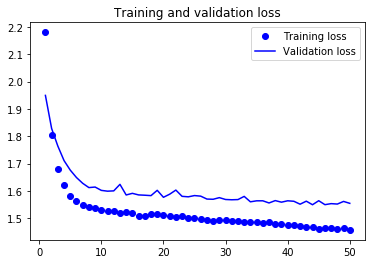

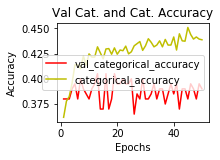

In [11]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score

cv = KFold(n_splits=5,shuffle=True)
results = []
y_pred_list = []

count = 1
for traincv, testcv in cv.split(X):
    print("\n--------Fold {}--------\n".format(count))
    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
    
    train_essays = X_train['essay']
    test_essays = X_test['essay']
    
    sentences = []
    
    for essay in train_essays:
            # Obtaining all sentences from the training essays.
            sentences += essay_to_sentences(essay, remove_stopwords = True)
            
    # Initializing variables for word2vec model.
    num_features = 300 
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3

    print("Training Word2Vec Model...")
    model = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,
                     window = context, sample = downsampling)
    
    model.init_sims(replace=True)
    model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

    clean_train_essays = []
    
    # Generate training and testing data word vectors.
    for essay_v in train_essays:
        clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)
    
    clean_test_essays = []
    for essay_v in test_essays:
        clean_test_essays.append(essay_to_wordlist( essay_v, remove_stopwords=True ))
    testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )
    

    trainDataVecs = np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    # Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    validsiz=200;
    
    y_train = y_train -1
    y_test = y_test-1
    x_val= testDataVecs[0:validsiz]
    y_val = y_test[0:validsiz]
    y_val = to_categorical(y_val, num_classes=12)    
    y_train = to_categorical(y_train, num_classes=12)

    lstm_model = get_model()
    #,validation_data=(x_val, y_val)
    history = lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=50,validation_data=(x_val, y_val))
    y_pred = lstm_model.predict(testDataVecs)
    # Save any one of the 8 models.
    if count == 1:
         lstm_model.save('final_lstm.h5')
    
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)
    '''
    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)
    '''
    
    import matplotlib.pyplot as plt
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


    plt.subplot(222)
    valacc = history.history['val_acc']
    acc = history.history['acc']
    plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
    plt.plot(epochs, acc, 'y', label='categorical_accuracy')
    plt.title('Val Cat. and Cat. Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    break
    count += 1


In [43]:
model = keras.models.load_model("final_lstm.h5")  # Load Keras model we learned using KerasPractice 
test = trainDataVecs[1:2]
test_p = y_train[1:2]
print(test_p)
model.predict(test)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


array([[1.8432736e-04, 6.3183904e-04, 5.1012635e-04, 2.4204850e-03,
        1.3749599e-03, 2.3709595e-02, 3.4940720e-02, 3.2466865e-01,
        2.4821348e-01, 2.5709864e-01, 8.0462538e-02, 2.5904387e-02]],
      dtype=float32)

In [72]:
X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.csv'), encoding='ISO-8859-1')
Xplus = pd.read_csv(os.path.join(DATASET_DIR, 'Prompt-1.csv'), encoding='ISO-8859-1')
X = (X[(X["essay_set"] == 1)])
#X = (X[(X["essay_set"] == 1)])
X = X.dropna(axis=1)
#newset = X.set_index('essay_id').join(Xplus.set_index('EssayID'))
newset =X.merge(Xplus,left_on='essay_id', right_on='EssayID')
print(newset.columns)
newset = newset[["essay_id","essay_set","essay", "domain1_score",'Content',
       'Organization', 'Word Choice', 'Sentence Fluency', 'Conventions']]
newset.to_csv("essay_set1_merged.csv",index=False);

Index(['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'domain1_score', 'domain1_score_copy', 'EssayID', 'Content',
       'Organization', 'Word Choice', 'Sentence Fluency', 'Conventions'],
      dtype='object')
